Tom Louwerse stores the raw simulation data that is used to produce the [Peilingwijzer](https://peilingwijzer.tomlouwerse.nl) in a file that can be downloaded via the following dynamic link:

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("https://d1bjgq97if6urz.cloudfront.net/Public/Peilingwijzer/Last/coa_seats.csv",
                   index_col=0, header=0)

Colors picked from the Peilingwijzer's colors to make the correspondence clearer:

In [7]:
colors = {
    "VVD": "#455493",
    "PVV": "#00B9FF",
    "CDA": "#00894B",
    "D66": "#4AAB2D",
    "GL": "#006B39",
    "SP": "#C73D77",
    "PvdA": "#9A0D1B",
    "CU": "#0094B4",
    "PvdD": "#EBC30A",
    "50PLUS": "#C2791E",
    "SGP": "#7F8084",
    "Denk": "#41BAC1",
    "FvD": "#6E0C13",
    "PvdT": "#F9E518",
    "JA21": "#242B56"
}

In [4]:
data.max().max()

45

In [5]:
hist_kwargs = dict(
#                alpha=0.8,
               stacked=True,
#                histtype='stepfilled',
#                density=True,
               figsize=(15,10)
)

<AxesSubplot:ylabel='Frequency'>

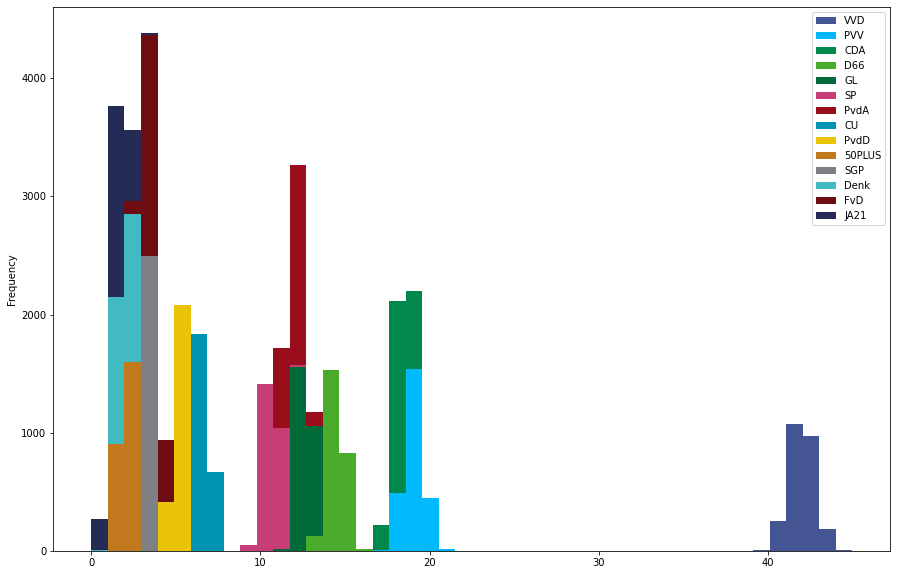

In [8]:
data.plot.hist(**hist_kwargs, bins=data.max().max() + 1, color=colors)

If you want to visualize coalitions in this way, you have to add up the counts per simulation and then visualize those numbers. For instance, let's take the VVD, PVV, CDA coalition, which at this point in time (10 November 2020) could form a majority, according to the sum of the polls' best estimates as published on the Peilingwijzer graph. And we compare to a huge left-wing-ish coalition.

In [9]:
coalitions = pd.DataFrame()

In [86]:
def sum_coalition(data, *parties):
    result = sum(data[party] for party in parties)
    if isinstance(result, int) and result == 0:
        return pd.Series([], dtype='int')
    else:
        return result

In [11]:
def add_coalition(coalitions_df, data, *parties, inplace=False):
    name = "+".join(parties)
    if not inplace:
        coalitions_df = coalitions_df.copy()
    coalitions_df[name] = sum_coalition(data, *parties)
    return coalitions_df

In [12]:
coalitions = add_coalition(coalitions, data, "VVD", "PVV", "CDA")

In [13]:
coalitions = add_coalition(coalitions, data, "GL", "SP", "PvdA", "PvdD", "Denk", "50PLUS")

In [14]:
coalitions

,VVD+PVV+CDA,GL+SP+PvdA+PvdD+Denk+50PLUS
result.1,80,41
result.2,80,42
result.3,80,43
result.4,82,43
result.5,78,42
...,...,...
result.2496,81,41
result.2497,79,44
result.2498,80,44
result.2499,79,44


<AxesSubplot:ylabel='Frequency'>

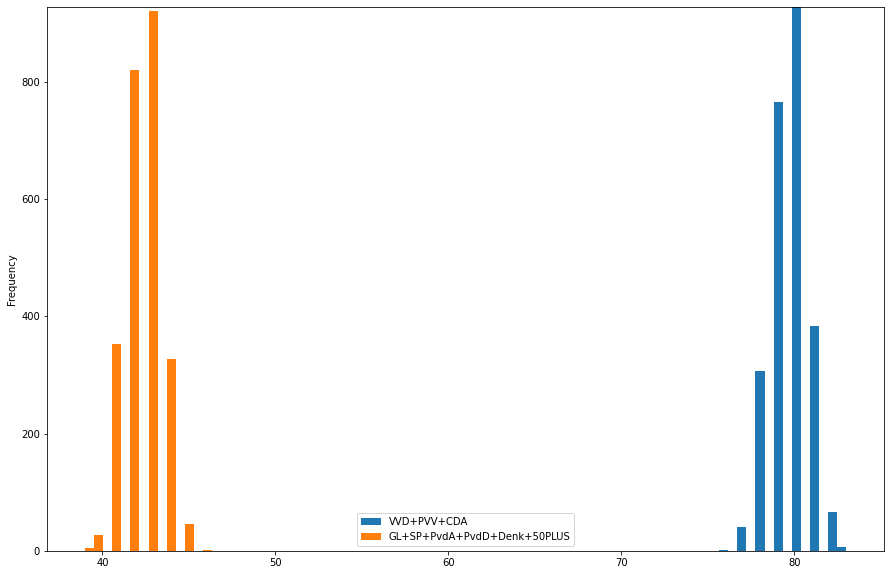

In [15]:
coalitions.plot.hist(
    **hist_kwargs,
    bins=coalitions.max().max() + 1
)

Now we have to still extract 95% confidence intervals. We can approximate by using mean and twice the standard deviation. Then round up, as is done in Peilingwijzer as well. Let's try it out for a few parties and see whether it matches.

In [16]:
import pickle
from collections import namedtuple
Peiling = namedtuple('Peiling', ['verwacht', 'laag', 'hoog'])
with open('peilingen.pkl', 'rb') as fh:
    numbers = pickle.load(fh)

In [17]:
import math

In [18]:
def compare_estimator_1(party):
    est = data[party].mean().round()
    interval = math.ceil((2 * data[party].std()))
    our_estimate = Peiling(verwacht=est, laag=max(0, est - interval), hoog=min(est + interval, 150))
    correct = numbers[party] == our_estimate
    return correct, {"correct": numbers[party], "ours": our_estimate, "mean": data[party].mean(), "2 x std": 2 * data[party].std()}

In [19]:
{party: compare_estimator_1(party) for party in data.columns}

{'VVD': (False,
  {'correct': Peiling(verwacht=43, laag=41, hoog=45),
   'ours': Peiling(verwacht=42.0, laag=40.0, hoog=44.0),
   'mean': 42.436,
   '2 x std': 1.5906690703086215}),
 'PVV': (True,
  {'correct': Peiling(verwacht=19, laag=17, hoog=21),
   'ours': Peiling(verwacht=19.0, laag=17.0, hoog=21.0),
   'mean': 18.9896,
   '2 x std': 1.2950050869668843}),
 'CDA': (False,
  {'correct': Peiling(verwacht=18, laag=17, hoog=19),
   'ours': Peiling(verwacht=18.0, laag=16.0, hoog=20.0),
   'mean': 18.1844,
   '2 x std': 1.1386418058655787}),
 'D66': (False,
  {'correct': Peiling(verwacht=14, laag=13, hoog=15),
   'ours': Peiling(verwacht=14.0, laag=12.0, hoog=16.0),
   'mean': 14.2928,
   '2 x std': 1.1426263072199854}),
 'GL': (True,
  {'correct': Peiling(verwacht=12, laag=11, hoog=13),
   'ours': Peiling(verwacht=12.0, laag=11.0, hoog=13.0),
   'mean': 12.3688,
   '2 x std': 0.9945561305219044}),
 'SP': (False,
  {'correct': Peiling(verwacht=10, laag=9, hoog=11),
   'ours': Peiling(ve

Ok, not completely there yet, then, but pretty close. Had to add clip below 0 (and, to be technically correct, above 150).

But then still there's a few things going wrong:

- Denk is not at the mean. Is the peak instead determined at the maximum probability peak?
- GL, CU and 50PLUS have a broader confidence interval in our estimate. Perhaps ceil is not the best rounding function. We could fiddle a bit with a weird rounder that rounds up above 0.25 and down below that, or some other value that fits the distributions best.

This is probably all due to the gaussian approximation we make here. The actual model is not a Gaussian, so mean and std are flawed estimators of the true confidence interval. Anyway, as long as it's close, we can always try the actual model later.

Let's first try to compare max likelihood peak:

In [20]:
data["Denk"].value_counts().index[0]

2

In [21]:
def compare_estimator_2():
    comparison = {}

    def estimate_Peiling(est, std):
        interval = math.ceil((2 * std))
        return Peiling(verwacht=est, laag=max(0, est - interval), hoog=min(est + interval, 150))

    def check_correctness(theirs, ours):
        correct = theirs == ours
        return correct, {"correct": theirs,
                         "ours": ours,
                         "mean": data[party].mean(),
                         "2 x std": 2 * data[party].std()}

    def compare_party(party):
        est = data[party].value_counts().index[0]
        our_estimate = estimate_Peiling(est, data[party].std())
        return check_correctness(numbers[party], our_estimate)

    for party in data.columns:
        comparison[party] = compare_party(party)

    # add missing seats if necessary
    while sum(ding[1]['ours'].verwacht for ding in comparison.values()) < 150:
        rest_values = {party: thing[1]["mean"] - thing[1]["ours"].verwacht for party, thing in comparison.items()}
        party_max_rest = max(rest_values.keys(), key=(lambda k: rest_values[k]))

        ours_new = estimate_Peiling(comparison[party_max_rest][1]["ours"].verwacht + 1,
                                    comparison[party_max_rest][1]["2 x std"] / 2)

        comparison[party_max_rest] = check_correctness(numbers[party_max_rest], ours_new)

    return comparison

In [22]:
comparison_2 = compare_estimator_2()
# comparison_2
{party: ding[0] for party, ding in comparison_2.items()}

{'VVD': True,
 'PVV': True,
 'CDA': False,
 'D66': False,
 'GL': True,
 'SP': False,
 'PvdA': False,
 'CU': True,
 'PvdD': True,
 '50PLUS': True,
 'SGP': True,
 'Denk': False,
 'FvD': True,
 'JA21': False}

In [23]:
sum(ding[1]['correct'].verwacht for ding in comparison_2.values())

150

In [24]:
sum(ding[1]['ours'].verwacht for ding in comparison_2.values())

150

Ah, ok, so Denk has to get a rest seat here, it seems.

Then, let's try the rounding fiddling to get the rest correct...

In [25]:
def compare_estimator_3(round_dec=0.15):
    comparison = {}

    def estimate_Peiling(est, std, round_dec=round_dec):
        two_std = 2 * std
        two_std_floor = math.floor(two_std)
        two_std_rest = two_std - two_std_floor
        if two_std_rest < round_dec:
            interval = two_std_floor
        else:
            interval = math.ceil(two_std)
        return Peiling(verwacht=est, laag=max(0, est - interval), hoog=min(est + interval, 150))

    def check_correctness(theirs, ours):
        correct = theirs == ours
        return correct, {"correct": theirs,
                         "ours": ours,
                         "mean": data[party].mean(),
                         "2 x std": 2 * data[party].std()}

    def compare_party(party):
        # max likelihood or mean makes no difference in practice
#         est = data[party].value_counts().index[0]
        est = data[party].mean().round()
        our_estimate = estimate_Peiling(est, data[party].std())
        return check_correctness(numbers[party], our_estimate)

    for party in data.columns:
        comparison[party] = compare_party(party)

    # add missing seats if necessary
    while sum(ding[1]['ours'].verwacht for ding in comparison.values()) < 150:
        rest_values = {party: thing[1]["mean"] - thing[1]["ours"].verwacht for party, thing in comparison.items()}
        party_max_rest = max(rest_values.keys(), key=(lambda k: rest_values[k]))

        ours_new = estimate_Peiling(comparison[party_max_rest][1]["ours"].verwacht + 1,
                                    comparison[party_max_rest][1]["2 x std"] / 2)

        comparison[party_max_rest] = check_correctness(numbers[party_max_rest], ours_new)

    return comparison

In [26]:
comparison_3 = compare_estimator_3()
{party: ding[0] for party, ding in comparison_3.items()}

{'VVD': True,
 'PVV': True,
 'CDA': True,
 'D66': True,
 'GL': True,
 'SP': True,
 'PvdA': True,
 'CU': True,
 'PvdD': True,
 '50PLUS': True,
 'SGP': False,
 'Denk': True,
 'FvD': True,
 'JA21': False}

In [27]:
comparison_3['GL']

(True,
 {'correct': Peiling(verwacht=12, laag=11, hoog=13),
  'ours': Peiling(verwacht=12.0, laag=11.0, hoog=13.0),
  'mean': 12.3688,
  '2 x std': 0.9945561305219044})

Ok, so this is still not perfect, but it's the closest we can get, with only one wrong fit.

On the other hand, maybe just using the gaussian approximation with rounding up is a safer way to go. We will have some wider uncertainty estimates, but we can take those to represent the fact that we do not actually use the right model.

So, let's go with estimation method 2 for the coalitions. Except, instead of max likelihood, we go back to mean, because it makes no difference in practice, but is unambiguous in case there are two equally likely bins in the histogram.

Also, let's do it with Python standard library stuff now to prepare for using it from Heroku with minimal dependencies.

In [28]:
import statistics

In [29]:
def to_Peiling_from_simulations(simulations):
    def estimate_Peiling(est, std):
        interval = math.ceil((2 * std))
        return Peiling(verwacht=int(est),
                       laag=int(max(0, est - interval)),
                       hoog=int(min(est + interval, 150)))

    est = round(statistics.mean(simulations))
    return estimate_Peiling(est, statistics.stdev(simulations))

In [30]:
{party: to_Peiling_from_simulations(data[party]) == numbers[party] for party in data.columns}

{'VVD': False,
 'PVV': True,
 'CDA': False,
 'D66': False,
 'GL': True,
 'SP': False,
 'PvdA': False,
 'CU': True,
 'PvdD': True,
 '50PLUS': True,
 'SGP': True,
 'Denk': False,
 'FvD': True,
 'JA21': False}

In [31]:
to_Peiling_from_simulations(coalitions["GL+SP+PvdA+PvdD+Denk+50PLUS"])

Peiling(verwacht=43, laag=41, hoog=45)

In [32]:
to_Peiling_from_simulations(coalitions["VVD+PVV+CDA"])

Peiling(verwacht=80, laag=77, hoog=83)

That was with a Pandas Series, but we can now also do it directly on a regular list:

In [33]:
to_Peiling_from_simulations(list(coalitions["VVD+PVV+CDA"]))

Peiling(verwacht=80, laag=77, hoog=83)

Now, when we do it for all parties, we should get a vanishing interval.

In [34]:
coalitions = add_coalition(coalitions, data, *data.columns)

In [35]:
coalitions.keys()

Index(['VVD+PVV+CDA', 'GL+SP+PvdA+PvdD+Denk+50PLUS',
       'VVD+PVV+CDA+D66+GL+SP+PvdA+CU+PvdD+50PLUS+SGP+Denk+FvD+JA21'],
      dtype='object')

In [38]:
to_Peiling_from_simulations(list(coalitions["VVD+PVV+CDA+D66+GL+SP+PvdA+CU+PvdD+50PLUS+SGP+Denk+FvD+JA21"]))

Peiling(verwacht=150, laag=150, hoog=150)

Cool!

In [39]:
to_Peiling_from_simulations(sum_coalition(data, *data.columns[:-1]))

Peiling(verwacht=149, laag=147, hoog=150)

Indeed, without PvdT (last in the list), which is estimated at 0, but could get 1, this is what you expect.

In [40]:
to_Peiling_from_simulations(sum_coalition(data, *data.columns[:-2]))

Peiling(verwacht=146, laag=144, hoog=148)

In [41]:
to_Peiling_from_simulations(data['FvD'])

Peiling(verwacht=3, laag=2, hoog=4)

FvD is second to last, so excluding it should indeed lower the estimate by 6. We see that the uncertainty of PvdT alone is no longer just "added" as we did before in the first Coalitiewijzer, but they are now combined into an uncertainty estimate that is apparently the same as that of FvD alone.

Time to build this into the Coalitiewijzer!

Save in native format:

In [42]:
import pickle

In [43]:
sims_df = pd.read_csv("https://d1bjgq97if6urz.cloudfront.net/Public/Peilingwijzer/Last/coa_seats.csv",
                       index_col=0, header=0)
sims = {party: tuple(sims_df[party]) for party in sims_df}

In [44]:
with open('simulations.pkl', 'wb') as fh:
    pickle.dump(sims, fh)

In [45]:
import itertools

In [46]:
list(itertools.product('abcd'))

[('a',), ('b',), ('c',), ('d',)]

In [47]:
%pip install more-itertools

You should consider upgrading via the '/Users/patrick/code/coalitiewijzer/.venv/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [48]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

In [49]:
import more_itertools

In [50]:
l = list(range(300))

In [51]:
%timeit more_itertools.powerset(l)
%timeit powerset(l)

1.6 µs ± 56.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.51 µs ± 50 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Ok, so `more_itertools` is not necessary for just this function.

In [52]:
list(powerset(sims.keys()))[1]

('VVD',)

Use some adapted function versions for use with Python native objects:

In [82]:
def to_Peiling_from_simulations(simulations):
    print(simulations)
    def estimate_Peiling(est, std):
        interval = math.ceil((2 * std))
        return Peiling(verwacht=int(est),
                       laag=int(max(0, est - interval)),
                       hoog=int(min(est + interval, 150)))

    if len(simulations) == 0:
        return Peiling(0, 0, 0)
    est = round(statistics.mean(simulations))
    return estimate_Peiling(est, statistics.stdev(simulations))

In [ ]:
%pip install tqdm

In [54]:
from tqdm.notebook import tqdm

In [61]:
sims[key[0]]

(43,
 43,
 43,
 43,
 41,
 43,
 41,
 42,
 43,
 43,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 43,
 42,
 42,
 44,
 44,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 42,
 44,
 42,
 41,
 42,
 43,
 41,
 42,
 42,
 43,
 42,
 43,
 42,
 43,
 45,
 42,
 43,
 42,
 43,
 41,
 42,
 42,
 43,
 43,
 43,
 43,
 43,
 43,
 44,
 43,
 42,
 43,
 42,
 42,
 42,
 42,
 43,
 43,
 41,
 43,
 44,
 42,
 42,
 41,
 43,
 43,
 42,
 43,
 43,
 42,
 42,
 42,
 44,
 42,
 43,
 43,
 42,
 44,
 43,
 42,
 42,
 43,
 43,
 43,
 43,
 43,
 42,
 41,
 42,
 43,
 41,
 44,
 43,
 44,
 43,
 42,
 43,
 43,
 41,
 42,
 42,
 43,
 42,
 42,
 41,
 41,
 43,
 42,
 43,
 42,
 41,
 43,
 42,
 43,
 43,
 41,
 42,
 43,
 43,
 43,
 44,
 43,
 42,
 42,
 43,
 43,
 42,
 44,
 42,
 42,
 41,
 42,
 41,
 42,
 42,
 42,
 42,
 41,
 43,
 42,
 43,
 42,
 43,
 43,
 43,
 43,
 42,
 43,
 43,
 43,
 43,
 42,
 42,
 41,
 43,
 44,
 43,
 43,
 42,
 42,
 42,
 42,
 42,
 42,
 41,
 42,
 41,
 43,
 41,
 42,
 43,
 42,
 42,
 41,
 43,
 43,
 41,
 42,
 40,
 42,
 42,
 41,
 42,
 43,
 42,
 42,
 43,
 43,
 43,


In [87]:
table = {}
for key in tqdm(powerset(sims.keys()), total=2**len(sims.keys())):
    table[key] = to_Peiling_from_simulations(sum_coalition(sims_df, *key))

Series([], dtype: int64)
result.1       43
result.2       43
result.3       43
result.4       43
result.5       41
               ..
result.2496    43
result.2497    42
result.2498    42
result.2499    42
result.2500    43
Name: VVD, Length: 2500, dtype: int64
result.1       19
result.2       19
result.3       19
result.4       20
result.5       19
               ..
result.2496    20
result.2497    19
result.2498    20
result.2499    19
result.2500    20
Name: PVV, Length: 2500, dtype: int64
result.1       18
result.2       18
result.3       18
result.4       19
result.5       18
               ..
result.2496    18
result.2497    18
result.2498    18
result.2499    18
result.2500    18
Name: CDA, Length: 2500, dtype: int64
result.1       15
result.2       14
result.3       14
result.4       13
result.5       15
               ..
result.2496    14
result.2497    13
result.2498    14
result.2499    14
result.2500    14
Name: D66, Length: 2500, dtype: int64
result.1       12
result.2     

result.1       19
result.2       20
result.3       20
result.4       21
result.5       19
               ..
result.2496    19
result.2497    19
result.2498    19
result.2499    19
result.2500    19
Length: 2500, dtype: int64
result.1       21
result.2       21
result.3       21
result.4       22
result.5       22
               ..
result.2496    21
result.2497    21
result.2498    21
result.2499    21
result.2500    21
Length: 2500, dtype: int64
result.1       19
result.2       19
result.3       19
result.4       19
result.5       20
               ..
result.2496    19
result.2497    20
result.2498    18
result.2499    19
result.2500    19
Length: 2500, dtype: int64
result.1       27
result.2       26
result.3       28
result.4       26
result.5       27
               ..
result.2496    26
result.2497    26
result.2498    27
result.2499    27
result.2500    27
Length: 2500, dtype: int64
result.1       25
result.2       24
result.3       24
result.4       24
result.5       26
          

result.1       4
result.2       5
result.3       5
result.4       5
result.5       5
              ..
result.2496    4
result.2497    4
result.2498    4
result.2499    4
result.2500    4
Length: 2500, dtype: int64
result.1       2
result.2       3
result.3       3
result.4       2
result.5       3
              ..
result.2496    2
result.2497    3
result.2498    1
result.2499    2
result.2500    2
Length: 2500, dtype: int64
result.1       4
result.2       4
result.3       4
result.4       3
result.5       6
              ..
result.2496    4
result.2497    5
result.2498    3
result.2499    4
result.2500    4
Length: 2500, dtype: int64
result.1       80
result.2       80
result.3       80
result.4       82
result.5       78
               ..
result.2496    81
result.2497    79
result.2498    80
result.2499    79
result.2500    81
Length: 2500, dtype: int64
result.1       77
result.2       76
result.3       76
result.4       76
result.5       75
               ..
result.2496    77
result.

result.1       56
result.2       56
result.3       56
result.4       57
result.5       55
               ..
result.2496    56
result.2497    56
result.2498    56
result.2499    56
result.2500    56
Length: 2500, dtype: int64
result.1       54
result.2       55
result.3       55
result.4       56
result.5       53
               ..
result.2496    54
result.2497    54
result.2498    54
result.2499    54
result.2500    54
Length: 2500, dtype: int64
result.1       56
result.2       56
result.3       56
result.4       57
result.5       56
               ..
result.2496    56
result.2497    56
result.2498    56
result.2499    56
result.2500    56
Length: 2500, dtype: int64
result.1       54
result.2       54
result.3       54
result.4       54
result.5       54
               ..
result.2496    54
result.2497    55
result.2498    53
result.2499    54
result.2500    54
Length: 2500, dtype: int64
result.1       62
result.2       62
result.3       61
result.4       60
result.5       59
          

result.1       46
result.2       45
result.3       47
result.4       46
result.5       46
               ..
result.2496    46
result.2497    45
result.2498    47
result.2499    46
result.2500    47
Length: 2500, dtype: int64
result.1       44
result.2       43
result.3       43
result.4       44
result.5       45
               ..
result.2496    44
result.2497    43
result.2498    45
result.2499    44
result.2500    44
Length: 2500, dtype: int64
result.1       46
result.2       45
result.3       45
result.4       44
result.5       46
               ..
result.2496    45
result.2497    44
result.2498    46
result.2499    45
result.2500    45
Length: 2500, dtype: int64
result.1       41
result.2       40
result.3       39
result.4       39
result.5       40
               ..
result.2496    41
result.2497    38
result.2498    40
result.2499    39
result.2500    41
Length: 2500, dtype: int64
result.1       39
result.2       37
result.3       37
result.4       38
result.5       38
          

Length: 2500, dtype: int64
result.1       23
result.2       24
result.3       24
result.4       25
result.5       23
               ..
result.2496    24
result.2497    23
result.2498    24
result.2499    23
result.2500    24
Length: 2500, dtype: int64
result.1       25
result.2       25
result.3       25
result.4       26
result.5       26
               ..
result.2496    26
result.2497    25
result.2498    26
result.2499    25
result.2500    26
Length: 2500, dtype: int64
result.1       23
result.2       23
result.3       23
result.4       23
result.5       24
               ..
result.2496    24
result.2497    24
result.2498    23
result.2499    23
result.2500    24
Length: 2500, dtype: int64
result.1       23
result.2       24
result.3       24
result.4       25
result.5       24
               ..
result.2496    24
result.2497    23
result.2498    24
result.2499    23
result.2500    24
Length: 2500, dtype: int64
result.1       21
result.2       22
result.3       22
result.4       22
r

Length: 2500, dtype: int64
result.1       26
result.2       27
result.3       26
result.4       27
result.5       25
               ..
result.2496    26
result.2497    25
result.2498    25
result.2499    25
result.2500    26
Length: 2500, dtype: int64
result.1       28
result.2       28
result.3       27
result.4       28
result.5       28
               ..
result.2496    28
result.2497    27
result.2498    27
result.2499    27
result.2500    28
Length: 2500, dtype: int64
result.1       26
result.2       26
result.3       25
result.4       25
result.5       26
               ..
result.2496    26
result.2497    26
result.2498    24
result.2499    25
result.2500    26
Length: 2500, dtype: int64
result.1       24
result.2       24
result.3       23
result.4       25
result.5       24
               ..
result.2496    25
result.2497    25
result.2498    25
result.2499    25
result.2500    24
Length: 2500, dtype: int64
result.1       26
result.2       25
result.3       25
result.4       27
r

result.1       28
result.2       28
result.3       27
result.4       25
result.5       29
               ..
result.2496    27
result.2497    27
result.2498    28
result.2499    28
result.2500    26
Length: 2500, dtype: int64
result.1       30
result.2       29
result.3       29
result.4       27
result.5       30
               ..
result.2496    28
result.2497    28
result.2498    29
result.2499    29
result.2500    28
Length: 2500, dtype: int64
result.1       28
result.2       28
result.3       28
result.4       26
result.5       28
               ..
result.2496    26
result.2497    26
result.2498    27
result.2499    27
result.2500    26
Length: 2500, dtype: int64
result.1       30
result.2       29
result.3       29
result.4       27
result.5       31
               ..
result.2496    28
result.2497    28
result.2498    29
result.2499    29
result.2500    28
Length: 2500, dtype: int64
result.1       28
result.2       27
result.3       27
result.4       24
result.5       29
          

result.1       22
result.2       22
result.3       23
result.4       22
result.5       21
               ..
result.2496    22
result.2497    22
result.2498    22
result.2499    22
result.2500    23
Length: 2500, dtype: int64
result.1       20
result.2       21
result.3       22
result.4       21
result.5       19
               ..
result.2496    20
result.2497    20
result.2498    20
result.2499    20
result.2500    21
Length: 2500, dtype: int64
result.1       22
result.2       22
result.3       23
result.4       22
result.5       22
               ..
result.2496    22
result.2497    22
result.2498    22
result.2499    22
result.2500    23
Length: 2500, dtype: int64
result.1       20
result.2       20
result.3       21
result.4       19
result.5       20
               ..
result.2496    20
result.2497    21
result.2498    19
result.2499    20
result.2500    21
Length: 2500, dtype: int64
result.1       18
result.2       18
result.3       19
result.4       19
result.5       18
          

Length: 2500, dtype: int64
result.1       20
result.2       21
result.3       20
result.4       19
result.5       19
               ..
result.2496    19
result.2497    19
result.2498    19
result.2499    19
result.2500    19
Length: 2500, dtype: int64
result.1       22
result.2       22
result.3       21
result.4       20
result.5       22
               ..
result.2496    21
result.2497    21
result.2498    21
result.2499    21
result.2500    21
Length: 2500, dtype: int64
result.1       20
result.2       20
result.3       19
result.4       17
result.5       20
               ..
result.2496    19
result.2497    20
result.2498    18
result.2499    19
result.2500    19
Length: 2500, dtype: int64
result.1       18
result.2       18
result.3       17
result.4       17
result.5       18
               ..
result.2496    18
result.2497    19
result.2498    19
result.2499    19
result.2500    17
Length: 2500, dtype: int64
result.1       20
result.2       19
result.3       19
result.4       19
r

result.1       3
result.2       5
result.3       4
result.4       3
result.5       5
              ..
result.2496    4
result.2497    5
result.2498    3
result.2499    4
result.2500    3
Length: 2500, dtype: int64
result.1       5
result.2       6
result.3       5
result.4       4
result.5       8
              ..
result.2496    6
result.2497    7
result.2498    5
result.2499    6
result.2500    5
Length: 2500, dtype: int64
result.1       7
result.2       8
result.3       8
result.4       8
result.5       8
              ..
result.2496    7
result.2497    7
result.2498    7
result.2499    7
result.2500    7
Length: 2500, dtype: int64
result.1       5
result.2       6
result.3       6
result.4       5
result.5       6
              ..
result.2496    5
result.2497    6
result.2498    4
result.2499    5
result.2500    5
Length: 2500, dtype: int64
result.1       7
result.2       7
result.3       7
result.4       6
result.5       9
              ..
result.2496    7
result.2497    8
result.2

result.1       73
result.2       74
result.3       74
result.4       76
result.5       72
               ..
result.2496    74
result.2497    73
result.2498    74
result.2499    73
result.2500    74
Length: 2500, dtype: int64
result.1       75
result.2       75
result.3       75
result.4       77
result.5       75
               ..
result.2496    76
result.2497    75
result.2498    76
result.2499    75
result.2500    76
Length: 2500, dtype: int64
result.1       73
result.2       73
result.3       73
result.4       74
result.5       73
               ..
result.2496    74
result.2497    74
result.2498    73
result.2499    73
result.2500    74
Length: 2500, dtype: int64
result.1       81
result.2       81
result.3       80
result.4       80
result.5       78
               ..
result.2496    81
result.2497    79
result.2498    80
result.2499    79
result.2500    81
Length: 2500, dtype: int64
result.1       79
result.2       78
result.3       78
result.4       79
result.5       76
          

result.1       78
result.2       77
result.3       79
result.4       80
result.5       75
               ..
result.2496    78
result.2497    78
result.2498    78
result.2499    78
result.2500    79
Length: 2500, dtype: int64
result.1       74
result.2       75
result.3       76
result.4       76
result.5       73
               ..
result.2496    75
result.2497    75
result.2498    75
result.2499    75
result.2500    75
Length: 2500, dtype: int64
result.1       76
result.2       76
result.3       78
result.4       78
result.5       74
               ..
result.2496    76
result.2497    76
result.2498    76
result.2499    76
result.2500    77
Length: 2500, dtype: int64
result.1       74
result.2       75
result.3       77
result.4       77
result.5       72
               ..
result.2496    74
result.2497    74
result.2498    74
result.2499    74
result.2500    75
Length: 2500, dtype: int64
result.1       76
result.2       76
result.3       78
result.4       78
result.5       75
          

Length: 2500, dtype: int64
result.1       75
result.2       73
result.3       75
result.4       74
result.5       72
               ..
result.2496    74
result.2497    73
result.2498    74
result.2499    74
result.2500    75
Length: 2500, dtype: int64
result.1       71
result.2       71
result.3       72
result.4       70
result.5       70
               ..
result.2496    71
result.2497    70
result.2498    71
result.2499    71
result.2500    71
Length: 2500, dtype: int64
result.1       73
result.2       72
result.3       74
result.4       72
result.5       71
               ..
result.2496    72
result.2497    71
result.2498    72
result.2499    72
result.2500    73
Length: 2500, dtype: int64
result.1       71
result.2       71
result.3       73
result.4       71
result.5       69
               ..
result.2496    70
result.2497    69
result.2498    70
result.2499    70
result.2500    71
Length: 2500, dtype: int64
result.1       73
result.2       72
result.3       74
result.4       72
r

Length: 2500, dtype: int64
result.1       62
result.2       61
result.3       61
result.4       59
result.5       62
               ..
result.2496    61
result.2497    60
result.2498    59
result.2499    60
result.2500    61
Length: 2500, dtype: int64
result.1       77
result.2       77
result.3       79
result.4       78
result.5       76
               ..
result.2496    76
result.2497    78
result.2498    78
result.2499    78
result.2500    77
Length: 2500, dtype: int64
result.1       72
result.2       72
result.3       73
result.4       73
result.5       70
               ..
result.2496    72
result.2497    72
result.2498    72
result.2499    72
result.2500    73
Length: 2500, dtype: int64
result.1       70
result.2       69
result.3       71
result.4       72
result.5       68
               ..
result.2496    70
result.2497    71
result.2498    71
result.2499    71
result.2500    71
Length: 2500, dtype: int64
result.1       66
result.2       67
result.3       68
result.4       68
r

result.1       66
result.2       67
result.3       66
result.4       66
result.5       66
               ..
result.2496    66
result.2497    67
result.2498    67
result.2499    67
result.2500    65
Length: 2500, dtype: int64
result.1       68
result.2       68
result.3       68
result.4       68
result.5       67
               ..
result.2496    67
result.2497    68
result.2498    68
result.2499    68
result.2500    67
Length: 2500, dtype: int64
result.1       66
result.2       67
result.3       67
result.4       67
result.5       65
               ..
result.2496    65
result.2497    66
result.2498    66
result.2499    66
result.2500    65
Length: 2500, dtype: int64
result.1       68
result.2       68
result.3       68
result.4       68
result.5       68
               ..
result.2496    67
result.2497    68
result.2498    68
result.2499    68
result.2500    67
Length: 2500, dtype: int64
result.1       66
result.2       66
result.3       66
result.4       65
result.5       66
          

result.1       56
result.2       56
result.3       54
result.4       55
result.5       53
               ..
result.2496    57
result.2497    55
result.2498    55
result.2499    55
result.2500    56
Length: 2500, dtype: int64
result.1       58
result.2       57
result.3       56
result.4       57
result.5       54
               ..
result.2496    58
result.2497    56
result.2498    56
result.2499    56
result.2500    58
Length: 2500, dtype: int64
result.1       56
result.2       56
result.3       55
result.4       56
result.5       52
               ..
result.2496    56
result.2497    54
result.2498    54
result.2499    54
result.2500    56
Length: 2500, dtype: int64
result.1       58
result.2       57
result.3       56
result.4       57
result.5       55
               ..
result.2496    58
result.2497    56
result.2498    56
result.2499    56
result.2500    58
Length: 2500, dtype: int64
result.1       56
result.2       55
result.3       54
result.4       54
result.5       53
          

Length: 2500, dtype: int64
result.1       61
result.2       61
result.3       63
result.4       63
result.5       61
               ..
result.2496    61
result.2497    62
result.2498    63
result.2499    62
result.2500    62
Length: 2500, dtype: int64
result.1       56
result.2       56
result.3       57
result.4       58
result.5       55
               ..
result.2496    57
result.2497    56
result.2498    57
result.2499    56
result.2500    58
Length: 2500, dtype: int64
result.1       54
result.2       53
result.3       55
result.4       57
result.5       53
               ..
result.2496    55
result.2497    55
result.2498    56
result.2499    55
result.2500    56
Length: 2500, dtype: int64
result.1       50
result.2       51
result.3       52
result.4       53
result.5       51
               ..
result.2496    52
result.2497    52
result.2498    53
result.2499    52
result.2500    52
Length: 2500, dtype: int64
result.1       52
result.2       52
result.3       54
result.4       55
r

result.1       47
result.2       47
result.3       48
result.4       47
result.5       48
               ..
result.2496    48
result.2497    47
result.2498    49
result.2499    48
result.2500    48
Length: 2500, dtype: int64
result.1       49
result.2       48
result.3       50
result.4       49
result.5       49
               ..
result.2496    49
result.2497    48
result.2498    50
result.2499    49
result.2500    50
Length: 2500, dtype: int64
result.1       47
result.2       47
result.3       49
result.4       48
result.5       47
               ..
result.2496    47
result.2497    46
result.2498    48
result.2499    47
result.2500    48
Length: 2500, dtype: int64
result.1       49
result.2       48
result.3       50
result.4       49
result.5       50
               ..
result.2496    49
result.2497    48
result.2498    50
result.2499    49
result.2500    50
Length: 2500, dtype: int64
result.1       47
result.2       46
result.3       48
result.4       46
result.5       48
          

Length: 2500, dtype: int64
result.1       48
result.2       48
result.3       49
result.4       50
result.5       48
               ..
result.2496    49
result.2497    49
result.2498    50
result.2499    49
result.2500    50
Length: 2500, dtype: int64
result.1       46
result.2       45
result.3       47
result.4       49
result.5       46
               ..
result.2496    47
result.2497    48
result.2498    49
result.2499    48
result.2500    48
Length: 2500, dtype: int64
result.1       42
result.2       43
result.3       44
result.4       45
result.5       44
               ..
result.2496    44
result.2497    45
result.2498    46
result.2499    45
result.2500    44
Length: 2500, dtype: int64
result.1       44
result.2       44
result.3       46
result.4       47
result.5       45
               ..
result.2496    45
result.2497    46
result.2498    47
result.2499    46
result.2500    46
Length: 2500, dtype: int64
result.1       42
result.2       43
result.3       45
result.4       46
r

result.1       37
result.2       38
result.3       37
result.4       39
result.5       37
               ..
result.2496    38
result.2497    37
result.2498    38
result.2499    37
result.2500    38
Length: 2500, dtype: int64
result.1       39
result.2       39
result.3       38
result.4       40
result.5       40
               ..
result.2496    40
result.2497    39
result.2498    40
result.2499    39
result.2500    40
Length: 2500, dtype: int64
result.1       37
result.2       37
result.3       36
result.4       37
result.5       38
               ..
result.2496    38
result.2497    38
result.2498    37
result.2499    37
result.2500    38
Length: 2500, dtype: int64
result.1       35
result.2       35
result.3       34
result.4       37
result.5       36
               ..
result.2496    37
result.2497    37
result.2498    38
result.2499    37
result.2500    36
Length: 2500, dtype: int64
result.1       37
result.2       36
result.3       36
result.4       39
result.5       37
          

result.1       30
result.2       31
result.3       29
result.4       30
result.5       30
               ..
result.2496    32
result.2497    30
result.2498    31
result.2499    30
result.2500    31
Length: 2500, dtype: int64
result.1       28
result.2       30
result.3       28
result.4       29
result.5       28
               ..
result.2496    30
result.2497    28
result.2498    29
result.2499    28
result.2500    29
Length: 2500, dtype: int64
result.1       30
result.2       31
result.3       29
result.4       30
result.5       31
               ..
result.2496    32
result.2497    30
result.2498    31
result.2499    30
result.2500    31
Length: 2500, dtype: int64
result.1       28
result.2       29
result.3       27
result.4       27
result.5       29
               ..
result.2496    30
result.2497    29
result.2498    28
result.2499    28
result.2500    29
Length: 2500, dtype: int64
result.1       30
result.2       31
result.3       30
result.4       31
result.5       29
          

result.1       50
result.2       48
result.3       48
result.4       48
result.5       49
               ..
result.2496    48
result.2497    48
result.2498    49
result.2499    49
result.2500    48
Length: 2500, dtype: int64
result.1       46
result.2       46
result.3       45
result.4       44
result.5       47
               ..
result.2496    45
result.2497    45
result.2498    46
result.2499    46
result.2500    44
Length: 2500, dtype: int64
result.1       48
result.2       47
result.3       47
result.4       46
result.5       48
               ..
result.2496    46
result.2497    46
result.2498    47
result.2499    47
result.2500    46
Length: 2500, dtype: int64
result.1       46
result.2       46
result.3       46
result.4       45
result.5       46
               ..
result.2496    44
result.2497    44
result.2498    45
result.2499    45
result.2500    44
Length: 2500, dtype: int64
result.1       48
result.2       47
result.3       47
result.4       46
result.5       49
          

Length: 2500, dtype: int64
result.1       43
result.2       43
result.3       45
result.4       43
result.5       44
               ..
result.2496    42
result.2497    45
result.2498    43
result.2499    44
result.2500    43
Length: 2500, dtype: int64
result.1       42
result.2       41
result.3       42
result.4       43
result.5       40
               ..
result.2496    42
result.2497    42
result.2498    42
result.2499    42
result.2500    43
Length: 2500, dtype: int64
result.1       38
result.2       39
result.3       39
result.4       39
result.5       38
               ..
result.2496    39
result.2497    39
result.2498    39
result.2499    39
result.2500    39
Length: 2500, dtype: int64
result.1       40
result.2       40
result.3       41
result.4       41
result.5       39
               ..
result.2496    40
result.2497    40
result.2498    40
result.2499    40
result.2500    41
Length: 2500, dtype: int64
result.1       38
result.2       39
result.3       40
result.4       40
r

Length: 2500, dtype: int64
result.1       36
result.2       36
result.3       35
result.4       36
result.5       36
               ..
result.2496    36
result.2497    37
result.2498    37
result.2499    37
result.2500    35
Length: 2500, dtype: int64
result.1       38
result.2       37
result.3       37
result.4       38
result.5       37
               ..
result.2496    37
result.2497    38
result.2498    38
result.2499    38
result.2500    37
Length: 2500, dtype: int64
result.1       36
result.2       36
result.3       36
result.4       37
result.5       35
               ..
result.2496    35
result.2497    36
result.2498    36
result.2499    36
result.2500    35
Length: 2500, dtype: int64
result.1       38
result.2       37
result.3       37
result.4       38
result.5       38
               ..
result.2496    37
result.2497    38
result.2498    38
result.2499    38
result.2500    37
Length: 2500, dtype: int64
result.1       36
result.2       35
result.3       35
result.4       35
r

Length: 2500, dtype: int64
result.1       23
result.2       25
result.3       24
result.4       25
result.5       24
               ..
result.2496    24
result.2497    24
result.2498    24
result.2499    24
result.2500    23
Length: 2500, dtype: int64
result.1       25
result.2       26
result.3       25
result.4       26
result.5       27
               ..
result.2496    26
result.2497    26
result.2498    26
result.2499    26
result.2500    25
Length: 2500, dtype: int64
result.1       23
result.2       24
result.3       23
result.4       23
result.5       25
               ..
result.2496    24
result.2497    25
result.2498    23
result.2499    24
result.2500    23
Length: 2500, dtype: int64
result.1       23
result.2       25
result.3       24
result.4       25
result.5       25
               ..
result.2496    24
result.2497    24
result.2498    24
result.2499    24
result.2500    23
Length: 2500, dtype: int64
result.1       21
result.2       23
result.3       22
result.4       22
r

result.1       29
result.2       30
result.3       31
result.4       29
result.5       30
               ..
result.2496    29
result.2497    29
result.2498    30
result.2499    30
result.2500    29
Length: 2500, dtype: int64
result.1       31
result.2       31
result.3       32
result.4       30
result.5       33
               ..
result.2496    31
result.2497    31
result.2498    32
result.2499    32
result.2500    31
Length: 2500, dtype: int64
result.1       29
result.2       29
result.3       30
result.4       27
result.5       31
               ..
result.2496    29
result.2497    30
result.2498    29
result.2499    30
result.2500    29
Length: 2500, dtype: int64
result.1       31
result.2       31
result.3       33
result.4       31
result.5       31
               ..
result.2496    30
result.2497    30
result.2498    31
result.2499    31
result.2500    31
Length: 2500, dtype: int64
result.1       33
result.2       32
result.3       34
result.4       32
result.5       34
          

Length: 2500, dtype: int64
result.1       37
result.2       36
result.3       35
result.4       33
result.5       36
               ..
result.2496    35
result.2497    34
result.2498    35
result.2499    35
result.2500    35
Length: 2500, dtype: int64
result.1       35
result.2       35
result.3       34
result.4       32
result.5       34
               ..
result.2496    33
result.2497    32
result.2498    33
result.2499    33
result.2500    33
Length: 2500, dtype: int64
result.1       37
result.2       36
result.3       35
result.4       33
result.5       37
               ..
result.2496    35
result.2497    34
result.2498    35
result.2499    35
result.2500    35
Length: 2500, dtype: int64
result.1       35
result.2       34
result.3       33
result.4       30
result.5       35
               ..
result.2496    33
result.2497    33
result.2498    32
result.2499    33
result.2500    33
Length: 2500, dtype: int64
result.1       33
result.2       32
result.3       31
result.4       30
r

result.1       20
result.2       20
result.3       19
result.4       17
result.5       22
               ..
result.2496    20
result.2497    20
result.2498    19
result.2499    20
result.2500    19
Length: 2500, dtype: int64
result.1       20
result.2       21
result.3       20
result.4       19
result.5       22
               ..
result.2496    20
result.2497    19
result.2498    20
result.2499    20
result.2500    19
Length: 2500, dtype: int64
result.1       18
result.2       19
result.3       18
result.4       16
result.5       20
               ..
result.2496    18
result.2497    18
result.2498    17
result.2499    18
result.2500    17
Length: 2500, dtype: int64
result.1       20
result.2       20
result.3       19
result.4       17
result.5       23
               ..
result.2496    20
result.2497    20
result.2498    19
result.2499    20
result.2500    19
Length: 2500, dtype: int64
result.1       22
result.2       22
result.3       22
result.4       21
result.5       23
          

result.1       26
result.2       27
result.3       29
result.4       26
result.5       27
               ..
result.2496    25
result.2497    28
result.2498    26
result.2499    27
result.2500    26
Length: 2500, dtype: int64
result.1       28
result.2       28
result.3       30
result.4       27
result.5       30
               ..
result.2496    27
result.2497    30
result.2498    28
result.2499    29
result.2500    28
Length: 2500, dtype: int64
result.1       25
result.2       25
result.3       25
result.4       25
result.5       24
               ..
result.2496    26
result.2497    26
result.2498    26
result.2499    26
result.2500    26
Length: 2500, dtype: int64
result.1       27
result.2       26
result.3       27
result.4       27
result.5       25
               ..
result.2496    27
result.2497    27
result.2498    27
result.2499    27
result.2500    28
Length: 2500, dtype: int64
result.1       25
result.2       25
result.3       26
result.4       26
result.5       23
          

result.1       24
result.2       25
result.3       24
result.4       23
result.5       27
               ..
result.2496    24
result.2497    27
result.2498    25
result.2499    26
result.2500    23
Length: 2500, dtype: int64
result.1       26
result.2       27
result.3       27
result.4       27
result.5       27
               ..
result.2496    25
result.2497    27
result.2498    27
result.2499    27
result.2500    25
Length: 2500, dtype: int64
result.1       28
result.2       28
result.3       28
result.4       28
result.5       30
               ..
result.2496    27
result.2497    29
result.2498    29
result.2499    29
result.2500    27
Length: 2500, dtype: int64
result.1       26
result.2       26
result.3       26
result.4       25
result.5       28
               ..
result.2496    25
result.2497    28
result.2498    26
result.2499    27
result.2500    25
Length: 2500, dtype: int64
result.1       26
result.2       27
result.3       27
result.4       27
result.5       28
          

result.1       23
result.2       24
result.3       23
result.4       22
result.5       22
               ..
result.2496    22
result.2497    22
result.2498    22
result.2499    22
result.2500    22
Length: 2500, dtype: int64
result.1       25
result.2       25
result.3       24
result.4       23
result.5       25
               ..
result.2496    24
result.2497    24
result.2498    24
result.2499    24
result.2500    24
Length: 2500, dtype: int64
result.1       23
result.2       23
result.3       22
result.4       20
result.5       23
               ..
result.2496    22
result.2497    23
result.2498    21
result.2499    22
result.2500    22
Length: 2500, dtype: int64
result.1       23
result.2       24
result.3       23
result.4       22
result.5       23
               ..
result.2496    22
result.2497    22
result.2498    22
result.2499    22
result.2500    22
Length: 2500, dtype: int64
result.1       21
result.2       22
result.3       21
result.4       19
result.5       21
          

Length: 2500, dtype: int64
result.1       12
result.2       13
result.3       12
result.4       11
result.5       13
               ..
result.2496    12
result.2497    12
result.2498    10
result.2499    11
result.2500    12
Length: 2500, dtype: int64
result.1       10
result.2       11
result.3       10
result.4       11
result.5       10
               ..
result.2496    11
result.2497    11
result.2498    11
result.2499    11
result.2500    10
Length: 2500, dtype: int64
result.1       12
result.2       12
result.3       11
result.4       12
result.5       13
               ..
result.2496    13
result.2497    13
result.2498    13
result.2499    13
result.2500    12
Length: 2500, dtype: int64
result.1       10
result.2       10
result.3        9
result.4        9
result.5       11
               ..
result.2496    11
result.2497    12
result.2498    10
result.2499    11
result.2500    10
Length: 2500, dtype: int64
result.1       10
result.2       11
result.3       10
result.4       11
r

result.1       99
result.2       99
result.3       98
result.4       99
result.5       96
               ..
result.2496    99
result.2497    97
result.2498    98
result.2499    97
result.2500    99
Length: 2500, dtype: int64
result.1       97
result.2       96
result.3       96
result.4       98
result.5       94
               ..
result.2496    97
result.2497    96
result.2498    97
result.2499    96
result.2500    97
Length: 2500, dtype: int64
result.1       93
result.2       94
result.3       93
result.4       94
result.5       92
               ..
result.2496    94
result.2497    93
result.2498    94
result.2499    93
result.2500    93
Length: 2500, dtype: int64
result.1       95
result.2       95
result.3       95
result.4       96
result.5       93
               ..
result.2496    95
result.2497    94
result.2498    95
result.2499    94
result.2500    95
Length: 2500, dtype: int64
result.1       93
result.2       94
result.3       94
result.4       95
result.5       91
          

result.1       94
result.2       93
result.3       92
result.4       93
result.5       92
               ..
result.2496    94
result.2497    91
result.2498    93
result.2499    92
result.2500    94
Length: 2500, dtype: int64
result.1       92
result.2       90
result.3       90
result.4       92
result.5       90
               ..
result.2496    92
result.2497    90
result.2498    92
result.2499    91
result.2500    92
Length: 2500, dtype: int64
result.1       88
result.2       88
result.3       87
result.4       88
result.5       88
               ..
result.2496    89
result.2497    87
result.2498    89
result.2499    88
result.2500    88
Length: 2500, dtype: int64
result.1       90
result.2       89
result.3       89
result.4       90
result.5       89
               ..
result.2496    90
result.2497    88
result.2498    90
result.2499    89
result.2500    90
Length: 2500, dtype: int64
result.1       88
result.2       88
result.3       88
result.4       89
result.5       87
          

result.1       89
result.2       89
result.3       91
result.4       90
result.5       87
               ..
result.2496    89
result.2497    89
result.2498    90
result.2499    89
result.2500    90
Length: 2500, dtype: int64
result.1       87
result.2       88
result.3       90
result.4       89
result.5       85
               ..
result.2496    87
result.2497    87
result.2498    88
result.2499    87
result.2500    88
Length: 2500, dtype: int64
result.1       89
result.2       89
result.3       91
result.4       90
result.5       88
               ..
result.2496    89
result.2497    89
result.2498    90
result.2499    89
result.2500    90
Length: 2500, dtype: int64
result.1       87
result.2       87
result.3       89
result.4       87
result.5       86
               ..
result.2496    87
result.2497    88
result.2498    87
result.2499    87
result.2500    88
Length: 2500, dtype: int64
result.1       86
result.2       85
result.3       86
result.4       87
result.5       82
          

Length: 2500, dtype: int64
result.1       86
result.2       85
result.3       84
result.4       85
result.5       82
               ..
result.2496    86
result.2497    84
result.2498    85
result.2499    84
result.2500    86
Length: 2500, dtype: int64
result.1       82
result.2       83
result.3       81
result.4       81
result.5       80
               ..
result.2496    83
result.2497    81
result.2498    82
result.2499    81
result.2500    82
Length: 2500, dtype: int64
result.1       84
result.2       84
result.3       83
result.4       83
result.5       81
               ..
result.2496    84
result.2497    82
result.2498    83
result.2499    82
result.2500    84
Length: 2500, dtype: int64
result.1       82
result.2       83
result.3       82
result.4       82
result.5       79
               ..
result.2496    82
result.2497    80
result.2498    81
result.2499    80
result.2500    82
Length: 2500, dtype: int64
result.1       84
result.2       84
result.3       83
result.4       83
r

Length: 2500, dtype: int64
result.1       67
result.2       68
result.3       68
result.4       68
result.5       67
               ..
result.2496    68
result.2497    67
result.2498    66
result.2499    66
result.2500    68
Length: 2500, dtype: int64
result.1       98
result.2       97
result.3       99
result.4       99
result.5       97
               ..
result.2496    97
result.2497    97
result.2498    98
result.2499    98
result.2500    98
Length: 2500, dtype: int64
result.1       100
result.2        99
result.3       101
result.4        99
result.5        98
              ... 
result.2496     98
result.2497     98
result.2498     99
result.2499     99
result.2500     99
Length: 2500, dtype: int64
result.1       95
result.2       94
result.3       95
result.4       94
result.5       92
               ..
result.2496    94
result.2497    92
result.2498    93
result.2499    93
result.2500    95
Length: 2500, dtype: int64
result.1       93
result.2       91
result.3       93
result.4

Length: 2500, dtype: int64
result.1       92
result.2       92
result.3       93
result.4       92
result.5       89
               ..
result.2496    91
result.2497    91
result.2498    91
result.2499    91
result.2500    92
Length: 2500, dtype: int64
result.1       90
result.2       89
result.3       91
result.4       91
result.5       87
               ..
result.2496    89
result.2497    90
result.2498    90
result.2499    90
result.2500    90
Length: 2500, dtype: int64
result.1       86
result.2       87
result.3       88
result.4       87
result.5       85
               ..
result.2496    86
result.2497    87
result.2498    87
result.2499    87
result.2500    86
Length: 2500, dtype: int64
result.1       88
result.2       88
result.3       90
result.4       89
result.5       86
               ..
result.2496    87
result.2497    88
result.2498    88
result.2499    88
result.2500    88
Length: 2500, dtype: int64
result.1       86
result.2       87
result.3       89
result.4       88
r

result.1       75
result.2       76
result.3       75
result.4       77
result.5       75
               ..
result.2496    76
result.2497    76
result.2498    76
result.2499    76
result.2500    75
Length: 2500, dtype: int64
result.1       73
result.2       75
result.3       74
result.4       76
result.5       73
               ..
result.2496    74
result.2497    74
result.2498    74
result.2499    74
result.2500    73
Length: 2500, dtype: int64
result.1       75
result.2       76
result.3       75
result.4       77
result.5       76
               ..
result.2496    76
result.2497    76
result.2498    76
result.2499    76
result.2500    75
Length: 2500, dtype: int64
result.1       73
result.2       74
result.3       73
result.4       74
result.5       74
               ..
result.2496    74
result.2497    75
result.2498    73
result.2499    74
result.2500    73
Length: 2500, dtype: int64
result.1       75
result.2       76
result.3       76
result.4       78
result.5       74
          

result.1       72
result.2       72
result.3       71
result.4       71
result.5       70
               ..
result.2496    72
result.2497    71
result.2498    69
result.2499    70
result.2500    72
Length: 2500, dtype: int64
result.1       72
result.2       73
result.3       72
result.4       73
result.5       70
               ..
result.2496    72
result.2497    70
result.2498    70
result.2499    70
result.2500    72
Length: 2500, dtype: int64
result.1       70
result.2       71
result.3       70
result.4       70
result.5       68
               ..
result.2496    70
result.2497    69
result.2498    67
result.2499    68
result.2500    70
Length: 2500, dtype: int64
result.1       72
result.2       72
result.3       71
result.4       71
result.5       71
               ..
result.2496    72
result.2497    71
result.2498    69
result.2499    70
result.2500    72
Length: 2500, dtype: int64
result.1       70
result.2       70
result.3       69
result.4       71
result.5       68
          

Length: 2500, dtype: int64
result.1       80
result.2       79
result.3       80
result.4       78
result.5       77
               ..
result.2496    79
result.2497    77
result.2498    78
result.2499    78
result.2500    80
Length: 2500, dtype: int64
result.1       78
result.2       78
result.3       79
result.4       77
result.5       75
               ..
result.2496    77
result.2497    75
result.2498    76
result.2499    76
result.2500    78
Length: 2500, dtype: int64
result.1       80
result.2       79
result.3       80
result.4       78
result.5       78
               ..
result.2496    79
result.2497    77
result.2498    78
result.2499    78
result.2500    80
Length: 2500, dtype: int64
result.1       78
result.2       77
result.3       78
result.4       75
result.5       76
               ..
result.2496    77
result.2497    76
result.2498    75
result.2499    76
result.2500    78
Length: 2500, dtype: int64
result.1       76
result.2       75
result.3       76
result.4       75
r

result.1       76
result.2       75
result.3       75
result.4       74
result.5       73
               ..
result.2496    74
result.2497    73
result.2498    74
result.2499    74
result.2500    74
Length: 2500, dtype: int64
result.1       78
result.2       76
result.3       76
result.4       75
result.5       76
               ..
result.2496    76
result.2497    75
result.2498    76
result.2499    76
result.2500    76
Length: 2500, dtype: int64
result.1       76
result.2       74
result.3       74
result.4       72
result.5       74
               ..
result.2496    74
result.2497    74
result.2498    73
result.2499    74
result.2500    74
Length: 2500, dtype: int64
result.1       74
result.2       74
result.3       73
result.4       71
result.5       73
               ..
result.2496    73
result.2497    72
result.2498    73
result.2499    73
result.2500    72
Length: 2500, dtype: int64
result.1       72
result.2       73
result.3       72
result.4       70
result.5       71
          

result.1       61
result.2       62
result.3       61
result.4       59
result.5       61
               ..
result.2496    61
result.2497    60
result.2498    59
result.2499    60
result.2500    60
Length: 2500, dtype: int64
result.1       63
result.2       63
result.3       62
result.4       60
result.5       64
               ..
result.2496    63
result.2497    62
result.2498    61
result.2499    62
result.2500    62
Length: 2500, dtype: int64
result.1       65
result.2       65
result.3       65
result.4       64
result.5       64
               ..
result.2496    64
result.2497    62
result.2498    63
result.2499    63
result.2500    64
Length: 2500, dtype: int64
result.1       63
result.2       63
result.3       63
result.4       61
result.5       62
               ..
result.2496    62
result.2497    61
result.2498    60
result.2499    61
result.2500    62
Length: 2500, dtype: int64
result.1       65
result.2       64
result.3       64
result.4       62
result.5       65
          

result.1       73
result.2       73
result.3       75
result.4       74
result.5       70
               ..
result.2496    72
result.2497    73
result.2498    73
result.2499    73
result.2500    73
Length: 2500, dtype: int64
result.1       75
result.2       74
result.3       76
result.4       75
result.5       73
               ..
result.2496    74
result.2497    75
result.2498    75
result.2499    75
result.2500    75
Length: 2500, dtype: int64
result.1       73
result.2       72
result.3       74
result.4       72
result.5       71
               ..
result.2496    72
result.2497    74
result.2498    72
result.2499    73
result.2500    73
Length: 2500, dtype: int64
result.1       71
result.2       72
result.3       73
result.4       71
result.5       70
               ..
result.2496    71
result.2497    72
result.2498    72
result.2499    72
result.2500    71
Length: 2500, dtype: int64
result.1       69
result.2       71
result.3       72
result.4       70
result.5       68
          

result.1       73
result.2       74
result.3       73
result.4       73
result.5       71
               ..
result.2496    72
result.2497    72
result.2498    72
result.2499    72
result.2500    72
Length: 2500, dtype: int64
result.1       75
result.2       75
result.3       74
result.4       74
result.5       74
               ..
result.2496    74
result.2497    74
result.2498    74
result.2499    74
result.2500    74
Length: 2500, dtype: int64
result.1       73
result.2       73
result.3       72
result.4       71
result.5       72
               ..
result.2496    72
result.2497    73
result.2498    71
result.2499    72
result.2500    72
Length: 2500, dtype: int64
result.1       71
result.2       71
result.3       70
result.4       71
result.5       70
               ..
result.2496    71
result.2497    72
result.2498    72
result.2499    72
result.2500    70
Length: 2500, dtype: int64
result.1       73
result.2       72
result.3       72
result.4       73
result.5       71
          

Length: 2500, dtype: int64
result.1       68
result.2       67
result.3       66
result.4       65
result.5       65
               ..
result.2496    67
result.2497    67
result.2498    65
result.2499    66
result.2500    67
Length: 2500, dtype: int64
result.1       66
result.2       67
result.3       65
result.4       64
result.5       64
               ..
result.2496    66
result.2497    65
result.2498    65
result.2499    65
result.2500    65
Length: 2500, dtype: int64
result.1       64
result.2       66
result.3       64
result.4       63
result.5       62
               ..
result.2496    64
result.2497    63
result.2498    63
result.2499    63
result.2500    63
Length: 2500, dtype: int64
result.1       66
result.2       67
result.3       65
result.4       64
result.5       65
               ..
result.2496    66
result.2497    65
result.2498    65
result.2499    65
result.2500    65
Length: 2500, dtype: int64
result.1       64
result.2       65
result.3       63
result.4       61
r

result.1       59
result.2       58
result.3       57
result.4       57
result.5       57
               ..
result.2496    59
result.2497    58
result.2498    56
result.2499    57
result.2500    59
Length: 2500, dtype: int64
result.1       55
result.2       57
result.3       55
result.4       55
result.5       53
               ..
result.2496    56
result.2497    54
result.2498    54
result.2499    54
result.2500    55
Length: 2500, dtype: int64
result.1       57
result.2       58
result.3       56
result.4       56
result.5       56
               ..
result.2496    58
result.2497    56
result.2498    56
result.2499    56
result.2500    57
Length: 2500, dtype: int64
result.1       55
result.2       56
result.3       54
result.4       53
result.5       54
               ..
result.2496    56
result.2497    55
result.2498    53
result.2499    54
result.2500    55
Length: 2500, dtype: int64
result.1       55
result.2       57
result.3       55
result.4       55
result.5       54
          

result.1       64
result.2       62
result.3       61
result.4       63
result.5       62
               ..
result.2496    64
result.2497    61
result.2498    63
result.2499    62
result.2500    64
Length: 2500, dtype: int64
result.1       60
result.2       60
result.3       58
result.4       59
result.5       60
               ..
result.2496    61
result.2497    58
result.2498    60
result.2499    59
result.2500    60
Length: 2500, dtype: int64
result.1       62
result.2       61
result.3       60
result.4       61
result.5       61
               ..
result.2496    62
result.2497    59
result.2498    61
result.2499    60
result.2500    62
Length: 2500, dtype: int64
result.1       60
result.2       60
result.3       59
result.4       60
result.5       59
               ..
result.2496    60
result.2497    57
result.2498    59
result.2499    58
result.2500    60
Length: 2500, dtype: int64
result.1       62
result.2       61
result.3       60
result.4       61
result.5       62
          

result.1       51
result.2       52
result.3       53
result.4       53
result.5       53
               ..
result.2496    53
result.2497    54
result.2498    53
result.2499    53
result.2500    53
Length: 2500, dtype: int64
result.1       53
result.2       54
result.3       56
result.4       57
result.5       53
               ..
result.2496    54
result.2497    54
result.2498    55
result.2499    54
result.2500    55
Length: 2500, dtype: int64
result.1       55
result.2       55
result.3       57
result.4       58
result.5       56
               ..
result.2496    56
result.2497    56
result.2498    57
result.2499    56
result.2500    57
Length: 2500, dtype: int64
result.1       53
result.2       53
result.3       55
result.4       55
result.5       54
               ..
result.2496    54
result.2497    55
result.2498    54
result.2499    54
result.2500    55
Length: 2500, dtype: int64
result.1       53
result.2       54
result.3       56
result.4       57
result.5       54
          

result.1       57
result.2       56
result.3       56
result.4       58
result.5       56
               ..
result.2496    57
result.2497    57
result.2498    58
result.2499    57
result.2500    57
Length: 2500, dtype: int64
result.1       55
result.2       55
result.3       55
result.4       57
result.5       54
               ..
result.2496    55
result.2497    55
result.2498    56
result.2499    55
result.2500    55
Length: 2500, dtype: int64
result.1       57
result.2       56
result.3       56
result.4       58
result.5       57
               ..
result.2496    57
result.2497    57
result.2498    58
result.2499    57
result.2500    57
Length: 2500, dtype: int64
result.1       55
result.2       54
result.3       54
result.4       55
result.5       55
               ..
result.2496    55
result.2497    56
result.2498    55
result.2499    55
result.2500    55
Length: 2500, dtype: int64
result.1       53
result.2       54
result.3       53
result.4       54
result.5       54
          

result.1       46
result.2       45
result.3       45
result.4       47
result.5       47
               ..
result.2496    47
result.2497    47
result.2498    46
result.2499    46
result.2500    47
Length: 2500, dtype: int64
result.1       42
result.2       44
result.3       43
result.4       45
result.5       43
               ..
result.2496    44
result.2497    43
result.2498    44
result.2499    43
result.2500    43
Length: 2500, dtype: int64
result.1       44
result.2       45
result.3       44
result.4       46
result.5       46
               ..
result.2496    46
result.2497    45
result.2498    46
result.2499    45
result.2500    45
Length: 2500, dtype: int64
result.1       42
result.2       43
result.3       42
result.4       43
result.5       44
               ..
result.2496    44
result.2497    44
result.2498    43
result.2499    43
result.2500    43
Length: 2500, dtype: int64
result.1       42
result.2       44
result.3       43
result.4       45
result.5       44
          

result.1       59
result.2       58
result.3       58
result.4       58
result.5       61
               ..
result.2496    58
result.2497    58
result.2498    60
result.2499    59
result.2500    58
Length: 2500, dtype: int64
result.1       57
result.2       56
result.3       56
result.4       55
result.5       59
               ..
result.2496    56
result.2497    57
result.2498    57
result.2499    57
result.2500    56
Length: 2500, dtype: int64
result.1       56
result.2       54
result.3       53
result.4       55
result.5       55
               ..
result.2496    56
result.2497    54
result.2498    56
result.2499    55
result.2500    56
Length: 2500, dtype: int64
result.1       52
result.2       52
result.3       50
result.4       51
result.5       53
               ..
result.2496    53
result.2497    51
result.2498    53
result.2499    52
result.2500    52
Length: 2500, dtype: int64
result.1       54
result.2       53
result.3       52
result.4       53
result.5       54
          

Length: 2500, dtype: int64
result.1       43
result.2       44
result.3       42
result.4       42
result.5       43
               ..
result.2496    44
result.2497    41
result.2498    43
result.2499    42
result.2500    43
Length: 2500, dtype: int64
result.1       45
result.2       45
result.3       43
result.4       43
result.5       46
               ..
result.2496    46
result.2497    43
result.2498    45
result.2499    44
result.2500    45
Length: 2500, dtype: int64
result.1       43
result.2       43
result.3       41
result.4       40
result.5       44
               ..
result.2496    44
result.2497    42
result.2498    42
result.2499    42
result.2500    43
Length: 2500, dtype: int64
result.1       45
result.2       45
result.3       44
result.4       44
result.5       44
               ..
result.2496    45
result.2497    42
result.2498    44
result.2499    43
result.2500    45
Length: 2500, dtype: int64
result.1       47
result.2       46
result.3       45
result.4       45
r

result.1       49
result.2       50
result.3       51
result.4       52
result.5       49
               ..
result.2496    50
result.2497    50
result.2498    51
result.2499    50
result.2500    51
Length: 2500, dtype: int64
result.1       51
result.2       51
result.3       52
result.4       53
result.5       52
               ..
result.2496    52
result.2497    52
result.2498    53
result.2499    52
result.2500    53
Length: 2500, dtype: int64
result.1       49
result.2       49
result.3       50
result.4       50
result.5       50
               ..
result.2496    50
result.2497    51
result.2498    50
result.2499    50
result.2500    51
Length: 2500, dtype: int64
result.1       47
result.2       47
result.3       48
result.4       50
result.5       48
               ..
result.2496    49
result.2497    50
result.2498    51
result.2499    50
result.2500    49
Length: 2500, dtype: int64
result.1       49
result.2       48
result.3       50
result.4       52
result.5       49
          

result.1       42
result.2       43
result.3       44
result.4       44
result.5       41
               ..
result.2496    43
result.2497    42
result.2498    43
result.2499    42
result.2500    44
Length: 2500, dtype: int64
result.1       44
result.2       44
result.3       45
result.4       45
result.5       44
               ..
result.2496    45
result.2497    44
result.2498    45
result.2499    44
result.2500    46
Length: 2500, dtype: int64
result.1       42
result.2       42
result.3       43
result.4       42
result.5       42
               ..
result.2496    43
result.2497    43
result.2498    42
result.2499    42
result.2500    44
Length: 2500, dtype: int64
result.1       42
result.2       43
result.3       44
result.4       44
result.5       42
               ..
result.2496    43
result.2497    42
result.2498    43
result.2499    42
result.2500    44
Length: 2500, dtype: int64
result.1       40
result.2       41
result.3       42
result.4       41
result.5       40
          

Length: 2500, dtype: int64
result.1       42
result.2       42
result.3       41
result.4       44
result.5       41
               ..
result.2496    43
result.2497    42
result.2498    43
result.2499    42
result.2500    43
Length: 2500, dtype: int64
result.1       44
result.2       43
result.3       42
result.4       45
result.5       44
               ..
result.2496    45
result.2497    44
result.2498    45
result.2499    44
result.2500    45
Length: 2500, dtype: int64
result.1       42
result.2       41
result.3       40
result.4       42
result.5       42
               ..
result.2496    43
result.2497    43
result.2498    42
result.2499    42
result.2500    43
Length: 2500, dtype: int64
result.1       40
result.2       41
result.3       39
result.4       41
result.5       41
               ..
result.2496    42
result.2497    41
result.2498    42
result.2499    41
result.2500    41
Length: 2500, dtype: int64
result.1       38
result.2       40
result.3       38
result.4       40
r

Length: 2500, dtype: int64
result.1       36
result.2       38
result.3       37
result.4       37
result.5       37
               ..
result.2496    37
result.2497    37
result.2498    38
result.2499    37
result.2500    36
Length: 2500, dtype: int64
result.1       38
result.2       39
result.3       38
result.4       38
result.5       40
               ..
result.2496    39
result.2497    39
result.2498    40
result.2499    39
result.2500    38
Length: 2500, dtype: int64
result.1       36
result.2       37
result.3       36
result.4       35
result.5       38
               ..
result.2496    37
result.2497    38
result.2498    37
result.2499    37
result.2500    36
Length: 2500, dtype: int64
result.1       36
result.2       38
result.3       37
result.4       37
result.5       38
               ..
result.2496    37
result.2497    37
result.2498    38
result.2499    37
result.2500    36
Length: 2500, dtype: int64
result.1       34
result.2       36
result.3       35
result.4       34
r

Length: 2500, dtype: int64
result.1       31
result.2       30
result.3       30
result.4       31
result.5       32
               ..
result.2496    32
result.2497    32
result.2498    31
result.2499    31
result.2500    32
Length: 2500, dtype: int64
result.1       29
result.2       29
result.3       29
result.4       30
result.5       30
               ..
result.2496    30
result.2497    30
result.2498    29
result.2499    29
result.2500    30
Length: 2500, dtype: int64
result.1       27
result.2       29
result.3       28
result.4       29
result.5       29
               ..
result.2496    29
result.2497    28
result.2498    29
result.2499    28
result.2500    28
Length: 2500, dtype: int64
result.1       25
result.2       27
result.3       26
result.4       26
result.5       27
               ..
result.2496    27
result.2497    27
result.2498    26
result.2499    26
result.2500    26
Length: 2500, dtype: int64
result.1       27
result.2       28
result.3       27
result.4       27
r

result.1       58
result.2       57
result.3       57
result.4       57
result.5       59
               ..
result.2496    56
result.2497    57
result.2498    58
result.2499    58
result.2500    56
Length: 2500, dtype: int64
result.1       56
result.2       56
result.3       56
result.4       56
result.5       57
               ..
result.2496    54
result.2497    55
result.2498    56
result.2499    56
result.2500    54
Length: 2500, dtype: int64
result.1       58
result.2       57
result.3       57
result.4       57
result.5       60
               ..
result.2496    56
result.2497    57
result.2498    58
result.2499    58
result.2500    56
Length: 2500, dtype: int64
result.1       56
result.2       55
result.3       55
result.4       54
result.5       58
               ..
result.2496    54
result.2497    56
result.2498    55
result.2499    56
result.2500    54
Length: 2500, dtype: int64
result.1       55
result.2       53
result.3       52
result.4       54
result.5       54
          

result.1       46
result.2       44
result.3       43
result.4       43
result.5       45
               ..
result.2496    45
result.2497    44
result.2498    43
result.2499    44
result.2500    45
Length: 2500, dtype: int64
result.1       44
result.2       44
result.3       42
result.4       42
result.5       44
               ..
result.2496    44
result.2497    42
result.2498    43
result.2499    43
result.2500    43
Length: 2500, dtype: int64
result.1       42
result.2       43
result.3       41
result.4       41
result.5       42
               ..
result.2496    42
result.2497    40
result.2498    41
result.2499    41
result.2500    41
Length: 2500, dtype: int64
result.1       44
result.2       44
result.3       42
result.4       42
result.5       45
               ..
result.2496    44
result.2497    42
result.2498    43
result.2499    43
result.2500    43
Length: 2500, dtype: int64
result.1       42
result.2       42
result.3       40
result.4       39
result.5       43
          

result.1       50
result.2       50
result.3       51
result.4       52
result.5       50
               ..
result.2496    50
result.2497    51
result.2498    51
result.2499    51
result.2500    51
Length: 2500, dtype: int64
result.1       48
result.2       49
result.3       50
result.4       51
result.5       48
               ..
result.2496    48
result.2497    49
result.2498    49
result.2499    49
result.2500    49
Length: 2500, dtype: int64
result.1       50
result.2       50
result.3       51
result.4       52
result.5       51
               ..
result.2496    50
result.2497    51
result.2498    51
result.2499    51
result.2500    51
Length: 2500, dtype: int64
result.1       48
result.2       48
result.3       49
result.4       49
result.5       49
               ..
result.2496    48
result.2497    50
result.2498    48
result.2499    49
result.2500    49
Length: 2500, dtype: int64
result.1       46
result.2       46
result.3       47
result.4       49
result.5       47
          

Length: 2500, dtype: int64
result.1       43
result.2       42
result.3       43
result.4       43
result.5       42
               ..
result.2496    43
result.2497    44
result.2498    42
result.2499    43
result.2500    44
Length: 2500, dtype: int64
result.1       41
result.2       42
result.3       42
result.4       42
result.5       41
               ..
result.2496    42
result.2497    42
result.2498    42
result.2499    42
result.2500    42
Length: 2500, dtype: int64
result.1       39
result.2       41
result.3       41
result.4       41
result.5       39
               ..
result.2496    40
result.2497    40
result.2498    40
result.2499    40
result.2500    40
Length: 2500, dtype: int64
result.1       41
result.2       42
result.3       42
result.4       42
result.5       42
               ..
result.2496    42
result.2497    42
result.2498    42
result.2499    42
result.2500    42
Length: 2500, dtype: int64
result.1       39
result.2       40
result.3       40
result.4       39
r

result.1       42
result.2       43
result.3       42
result.4       42
result.5       45
               ..
result.2496    42
result.2497    45
result.2498    43
result.2499    44
result.2500    41
Length: 2500, dtype: int64
result.1       44
result.2       45
result.3       45
result.4       46
result.5       45
               ..
result.2496    43
result.2497    45
result.2498    45
result.2499    45
result.2500    43
Length: 2500, dtype: int64
result.1       46
result.2       46
result.3       46
result.4       47
result.5       48
               ..
result.2496    45
result.2497    47
result.2498    47
result.2499    47
result.2500    45
Length: 2500, dtype: int64
result.1       44
result.2       44
result.3       44
result.4       44
result.5       46
               ..
result.2496    43
result.2497    46
result.2498    44
result.2499    45
result.2500    43
Length: 2500, dtype: int64
result.1       44
result.2       45
result.3       45
result.4       46
result.5       46
          

result.1       41
result.2       42
result.3       41
result.4       41
result.5       40
               ..
result.2496    40
result.2497    40
result.2498    40
result.2499    40
result.2500    40
Length: 2500, dtype: int64
result.1       43
result.2       43
result.3       42
result.4       42
result.5       43
               ..
result.2496    42
result.2497    42
result.2498    42
result.2499    42
result.2500    42
Length: 2500, dtype: int64
result.1       41
result.2       41
result.3       40
result.4       39
result.5       41
               ..
result.2496    40
result.2497    41
result.2498    39
result.2499    40
result.2500    40
Length: 2500, dtype: int64
result.1       41
result.2       42
result.3       41
result.4       41
result.5       41
               ..
result.2496    40
result.2497    40
result.2498    40
result.2499    40
result.2500    40
Length: 2500, dtype: int64
result.1       39
result.2       40
result.3       39
result.4       38
result.5       39
          

result.1       28
result.2       29
result.3       28
result.4       30
result.5       28
               ..
result.2496    29
result.2497    29
result.2498    29
result.2499    29
result.2500    28
Length: 2500, dtype: int64
result.1       30
result.2       30
result.3       29
result.4       31
result.5       31
               ..
result.2496    31
result.2497    31
result.2498    31
result.2499    31
result.2500    30
Length: 2500, dtype: int64
result.1       28
result.2       28
result.3       27
result.4       28
result.5       29
               ..
result.2496    29
result.2497    30
result.2498    28
result.2499    29
result.2500    28
Length: 2500, dtype: int64
result.1       28
result.2       29
result.3       28
result.4       30
result.5       29
               ..
result.2496    29
result.2497    29
result.2498    29
result.2499    29
result.2500    28
Length: 2500, dtype: int64
result.1       26
result.2       27
result.3       26
result.4       27
result.5       27
          

Length: 2500, dtype: int64
result.1       49
result.2       48
result.3       49
result.4       46
result.5       49
               ..
result.2496    47
result.2497    47
result.2498    48
result.2499    48
result.2500    48
Length: 2500, dtype: int64
result.1       47
result.2       46
result.3       47
result.4       43
result.5       47
               ..
result.2496    45
result.2497    46
result.2498    45
result.2499    46
result.2500    46
Length: 2500, dtype: int64
result.1       45
result.2       44
result.3       45
result.4       43
result.5       45
               ..
result.2496    44
result.2497    45
result.2498    46
result.2499    46
result.2500    44
Length: 2500, dtype: int64
result.1       47
result.2       45
result.3       47
result.4       45
result.5       46
               ..
result.2496    45
result.2497    46
result.2498    47
result.2499    47
result.2500    46
Length: 2500, dtype: int64
result.1       45
result.2       44
result.3       46
result.4       44
r

result.1       36
result.2       35
result.3       37
result.4       36
result.5       36
               ..
result.2496    35
result.2497    35
result.2498    36
result.2499    36
result.2500    36
Length: 2500, dtype: int64
result.1       34
result.2       33
result.3       35
result.4       33
result.5       34
               ..
result.2496    33
result.2497    34
result.2498    33
result.2499    34
result.2500    34
Length: 2500, dtype: int64
result.1       36
result.2       34
result.3       36
result.4       34
result.5       37
               ..
result.2496    35
result.2497    36
result.2498    35
result.2499    36
result.2500    36
Length: 2500, dtype: int64
result.1       32
result.2       33
result.3       34
result.4       32
result.5       33
               ..
result.2496    32
result.2497    32
result.2498    33
result.2499    33
result.2500    32
Length: 2500, dtype: int64
result.1       34
result.2       34
result.3       35
result.4       33
result.5       36
          

Length: 2500, dtype: int64
result.1       32
result.2       31
result.3       30
result.4       30
result.5       34
               ..
result.2496    32
result.2497    33
result.2498    32
result.2499    33
result.2500    31
Length: 2500, dtype: int64
result.1       34
result.2       33
result.3       33
result.4       34
result.5       34
               ..
result.2496    33
result.2497    33
result.2498    34
result.2499    34
result.2500    33
Length: 2500, dtype: int64
result.1       36
result.2       34
result.3       34
result.4       35
result.5       37
               ..
result.2496    35
result.2497    35
result.2498    36
result.2499    36
result.2500    35
Length: 2500, dtype: int64
result.1       34
result.2       32
result.3       32
result.4       32
result.5       35
               ..
result.2496    33
result.2497    34
result.2498    33
result.2499    34
result.2500    33
Length: 2500, dtype: int64
result.1       34
result.2       33
result.3       33
result.4       34
r

result.1       29
result.2       29
result.3       27
result.4       27
result.5       28
               ..
result.2496    29
result.2497    27
result.2498    28
result.2499    28
result.2500    28
Length: 2500, dtype: int64
result.1       31
result.2       30
result.3       28
result.4       28
result.5       31
               ..
result.2496    31
result.2497    29
result.2498    30
result.2499    30
result.2500    30
Length: 2500, dtype: int64
result.1       29
result.2       28
result.3       26
result.4       25
result.5       29
               ..
result.2496    29
result.2497    28
result.2498    27
result.2499    28
result.2500    28
Length: 2500, dtype: int64
result.1       31
result.2       30
result.3       29
result.4       29
result.5       29
               ..
result.2496    30
result.2497    28
result.2498    29
result.2499    29
result.2500    30
Length: 2500, dtype: int64
result.1       33
result.2       31
result.3       30
result.4       30
result.5       32
          

Length: 2500, dtype: int64
result.1       42
result.2       42
result.3       43
result.4       41
result.5       43
               ..
result.2496    41
result.2497    44
result.2498    42
result.2499    43
result.2500    42
Length: 2500, dtype: int64
result.1       40
result.2       40
result.3       41
result.4       41
result.5       41
               ..
result.2496    40
result.2497    43
result.2498    43
result.2499    43
result.2500    40
Length: 2500, dtype: int64
result.1       42
result.2       41
result.3       43
result.4       43
result.5       42
               ..
result.2496    41
result.2497    44
result.2498    44
result.2499    44
result.2500    42
Length: 2500, dtype: int64
result.1       40
result.2       40
result.3       42
result.4       42
result.5       40
               ..
result.2496    39
result.2497    42
result.2498    42
result.2499    42
result.2500    40
Length: 2500, dtype: int64
result.1       42
result.2       41
result.3       43
result.4       43
r

result.1       25
result.2       27
result.3       28
result.4       27
result.5       28
               ..
result.2496    26
result.2497    29
result.2498    27
result.2499    28
result.2500    26
Length: 2500, dtype: int64
result.1       27
result.2       28
result.3       29
result.4       28
result.5       31
               ..
result.2496    28
result.2497    31
result.2498    29
result.2499    30
result.2500    28
Length: 2500, dtype: int64
result.1       29
result.2       30
result.3       32
result.4       32
result.5       31
               ..
result.2496    29
result.2497    31
result.2498    31
result.2499    31
result.2500    30
Length: 2500, dtype: int64
result.1       27
result.2       28
result.3       30
result.4       29
result.5       29
               ..
result.2496    27
result.2497    30
result.2498    28
result.2499    29
result.2500    28
Length: 2500, dtype: int64
result.1       29
result.2       29
result.3       31
result.4       30
result.5       32
          

Length: 2500, dtype: int64
result.1       22
result.2       24
result.3       24
result.4       22
result.5       23
               ..
result.2496    23
result.2497    24
result.2498    22
result.2499    23
result.2500    23
Length: 2500, dtype: int64
result.1       24
result.2       25
result.3       25
result.4       23
result.5       26
               ..
result.2496    25
result.2497    26
result.2498    24
result.2499    25
result.2500    25
Length: 2500, dtype: int64
result.1       26
result.2       27
result.3       28
result.4       27
result.5       26
               ..
result.2496    26
result.2497    26
result.2498    26
result.2499    26
result.2500    27
Length: 2500, dtype: int64
result.1       24
result.2       25
result.3       26
result.4       24
result.5       24
               ..
result.2496    24
result.2497    25
result.2498    23
result.2499    24
result.2500    25
Length: 2500, dtype: int64
result.1       26
result.2       26
result.3       27
result.4       25
r

result.1       29
result.2       30
result.3       30
result.4       30
result.5       31
               ..
result.2496    28
result.2497    30
result.2498    30
result.2499    30
result.2500    28
Length: 2500, dtype: int64
result.1       27
result.2       28
result.3       28
result.4       27
result.5       29
               ..
result.2496    26
result.2497    29
result.2498    27
result.2499    28
result.2500    26
Length: 2500, dtype: int64
result.1       29
result.2       29
result.3       29
result.4       28
result.5       32
               ..
result.2496    28
result.2497    31
result.2498    29
result.2499    30
result.2500    28
Length: 2500, dtype: int64
result.1       27
result.2       28
result.3       28
result.4       27
result.5       30
               ..
result.2496    26
result.2497    29
result.2498    27
result.2499    28
result.2500    26
Length: 2500, dtype: int64
result.1       26
result.2       26
result.3       24
result.4       26
result.5       26
          

result.1       28
result.2       28
result.3       26
result.4       26
result.5       27
               ..
result.2496    28
result.2497    28
result.2498    28
result.2499    28
result.2500    27
Length: 2500, dtype: int64
result.1       26
result.2       27
result.3       25
result.4       25
result.5       25
               ..
result.2496    26
result.2497    26
result.2498    26
result.2499    26
result.2500    25
Length: 2500, dtype: int64
result.1       28
result.2       28
result.3       26
result.4       26
result.5       28
               ..
result.2496    28
result.2497    28
result.2498    28
result.2499    28
result.2500    27
Length: 2500, dtype: int64
result.1       26
result.2       26
result.3       24
result.4       23
result.5       26
               ..
result.2496    26
result.2497    27
result.2498    25
result.2499    26
result.2500    25
Length: 2500, dtype: int64
result.1       28
result.2       28
result.3       27
result.4       27
result.5       26
          

Length: 2500, dtype: int64
result.1       13
result.2       15
result.3       13
result.4       12
result.5       14
               ..
result.2496    14
result.2497    14
result.2498    12
result.2499    13
result.2500    13
Length: 2500, dtype: int64
result.1       15
result.2       16
result.3       14
result.4       13
result.5       17
               ..
result.2496    16
result.2497    16
result.2498    14
result.2499    15
result.2500    15
Length: 2500, dtype: int64
result.1       13
result.2       15
result.3       13
result.4       12
result.5       15
               ..
result.2496    14
result.2497    14
result.2498    12
result.2499    13
result.2500    13
Length: 2500, dtype: int64
result.1       15
result.2       16
result.3       15
result.4       14
result.5       16
               ..
result.2496    15
result.2497    15
result.2498    13
result.2499    14
result.2500    15
Length: 2500, dtype: int64
result.1       13
result.2       14
result.3       13
result.4       14
r

Length: 2500, dtype: int64
result.1       103
result.2       101
result.3       101
result.4       103
result.5       100
              ... 
result.2496    103
result.2497    100
result.2498    102
result.2499    101
result.2500    103
Length: 2500, dtype: int64
result.1       101
result.2       100
result.3       100
result.4       102
result.5        98
              ... 
result.2496    101
result.2497     98
result.2498    100
result.2499     99
result.2500    101
Length: 2500, dtype: int64
result.1       103
result.2       101
result.3       101
result.4       103
result.5       101
              ... 
result.2496    103
result.2497    100
result.2498    102
result.2499    101
result.2500    103
Length: 2500, dtype: int64
result.1       101
result.2        99
result.3        99
result.4       100
result.5        99
              ... 
result.2496    101
result.2497     99
result.2498     99
result.2499     99
result.2500    101
Length: 2500, dtype: int64
result.1        99
result.2  

result.1        98
result.2        97
result.3        99
result.4       100
result.5        96
              ... 
result.2496     99
result.2497     99
result.2498     98
result.2499     98
result.2500    100
Length: 2500, dtype: int64
result.1       96
result.2       97
result.3       98
result.4       99
result.5       95
               ..
result.2496    98
result.2497    97
result.2498    98
result.2499    97
result.2500    98
Length: 2500, dtype: int64
result.1       94
result.2       96
result.3       97
result.4       98
result.5       93
               ..
result.2496    96
result.2497    95
result.2498    96
result.2499    95
result.2500    96
Length: 2500, dtype: int64
result.1       96
result.2       97
result.3       98
result.4       99
result.5       96
               ..
result.2496    98
result.2497    97
result.2498    98
result.2499    97
result.2500    98
Length: 2500, dtype: int64
result.1       94
result.2       95
result.3       96
result.4       96
result.5       94

Length: 2500, dtype: int64
result.1       100
result.2       100
result.3        99
result.4        99
result.5        98
              ... 
result.2496    100
result.2497     99
result.2498     98
result.2499     98
result.2500    100
Length: 2500, dtype: int64
result.1       98
result.2       98
result.3       97
result.4       99
result.5       96
               ..
result.2496    99
result.2497    98
result.2498    99
result.2499    98
result.2500    98
Length: 2500, dtype: int64
result.1       100
result.2        99
result.3        99
result.4       101
result.5        97
              ... 
result.2496    100
result.2497     99
result.2498    100
result.2499     99
result.2500    100
Length: 2500, dtype: int64
result.1        98
result.2        98
result.3        98
result.4       100
result.5        95
              ... 
result.2496     98
result.2497     97
result.2498     98
result.2499     97
result.2500     98
Length: 2500, dtype: int64
result.1       100
result.2        99
re

result.1       87
result.2       88
result.3       88
result.4       90
result.5       86
               ..
result.2496    88
result.2497    86
result.2498    87
result.2499    86
result.2500    88
Length: 2500, dtype: int64
result.1       85
result.2       86
result.3       86
result.4       87
result.5       84
               ..
result.2496    86
result.2497    85
result.2498    84
result.2499    84
result.2500    86
Length: 2500, dtype: int64
result.1       87
result.2       87
result.3       87
result.4       88
result.5       87
               ..
result.2496    88
result.2497    87
result.2498    86
result.2499    86
result.2500    88
Length: 2500, dtype: int64
result.1       85
result.2       86
result.3       86
result.4       87
result.5       85
               ..
result.2496    86
result.2497    85
result.2498    84
result.2499    84
result.2500    86
Length: 2500, dtype: int64
result.1       111
result.2       110
result.3       112
result.4       111
result.5       110
     

Length: 2500, dtype: int64
result.1       102
result.2       101
result.3       101
result.4       101
result.5       101
              ... 
result.2496    101
result.2497    100
result.2498    102
result.2499    101
result.2500    101
Length: 2500, dtype: int64
result.1       100
result.2       100
result.3       100
result.4       100
result.5        99
              ... 
result.2496     99
result.2497     98
result.2498    100
result.2499     99
result.2500     99
Length: 2500, dtype: int64
result.1       102
result.2       101
result.3       101
result.4       101
result.5       102
              ... 
result.2496    101
result.2497    100
result.2498    102
result.2499    101
result.2500    101
Length: 2500, dtype: int64
result.1       100
result.2        99
result.3        99
result.4        98
result.5       100
              ... 
result.2496     99
result.2497     99
result.2498     99
result.2499     99
result.2500     99
Length: 2500, dtype: int64
result.1       99
result.2   

Length: 2500, dtype: int64
result.1       91
result.2       91
result.3       90
result.4       88
result.5       91
               ..
result.2496    91
result.2497    90
result.2498    90
result.2499    90
result.2500    90
Length: 2500, dtype: int64
result.1       93
result.2       93
result.3       93
result.4       92
result.5       91
               ..
result.2496    92
result.2497    90
result.2498    92
result.2499    91
result.2500    92
Length: 2500, dtype: int64
result.1       95
result.2       94
result.3       94
result.4       93
result.5       94
               ..
result.2496    94
result.2497    92
result.2498    94
result.2499    93
result.2500    94
Length: 2500, dtype: int64
result.1       93
result.2       92
result.3       92
result.4       90
result.5       92
               ..
result.2496    92
result.2497    91
result.2498    91
result.2499    91
result.2500    92
Length: 2500, dtype: int64
result.1       93
result.2       93
result.3       93
result.4       92
r

result.1       97
result.2       97
result.3       99
result.4       98
result.5       97
               ..
result.2496    97
result.2497    99
result.2498    98
result.2499    98
result.2500    98
Length: 2500, dtype: int64
result.1       96
result.2       95
result.3       96
result.4       98
result.5       93
               ..
result.2496    97
result.2497    96
result.2498    97
result.2499    96
result.2500    98
Length: 2500, dtype: int64
result.1       92
result.2       93
result.3       93
result.4       94
result.5       91
               ..
result.2496    94
result.2497    93
result.2498    94
result.2499    93
result.2500    94
Length: 2500, dtype: int64
result.1       94
result.2       94
result.3       95
result.4       96
result.5       92
               ..
result.2496    95
result.2497    94
result.2498    95
result.2499    94
result.2500    96
Length: 2500, dtype: int64
result.1       92
result.2       93
result.3       94
result.4       95
result.5       90
          

Length: 2500, dtype: int64
result.1       85
result.2       86
result.3       87
result.4       87
result.5       82
               ..
result.2496    86
result.2497    84
result.2498    85
result.2499    84
result.2500    87
Length: 2500, dtype: int64
result.1       87
result.2       87
result.3       88
result.4       88
result.5       85
               ..
result.2496    88
result.2497    86
result.2498    87
result.2499    86
result.2500    89
Length: 2500, dtype: int64
result.1       85
result.2       85
result.3       86
result.4       85
result.5       83
               ..
result.2496    86
result.2497    85
result.2498    84
result.2499    84
result.2500    87
Length: 2500, dtype: int64
result.1       85
result.2       86
result.3       87
result.4       87
result.5       83
               ..
result.2496    86
result.2497    84
result.2498    85
result.2499    84
result.2500    87
Length: 2500, dtype: int64
result.1       83
result.2       84
result.3       85
result.4       84
r

result.1       85
result.2       85
result.3       83
result.4       86
result.5       83
               ..
result.2496    87
result.2497    85
result.2498    86
result.2499    85
result.2500    86
Length: 2500, dtype: int64
result.1       87
result.2       86
result.3       85
result.4       88
result.5       84
               ..
result.2496    88
result.2497    86
result.2498    87
result.2499    86
result.2500    88
Length: 2500, dtype: int64
result.1       85
result.2       85
result.3       84
result.4       87
result.5       82
               ..
result.2496    86
result.2497    84
result.2498    85
result.2499    84
result.2500    86
Length: 2500, dtype: int64
result.1       87
result.2       86
result.3       85
result.4       88
result.5       85
               ..
result.2496    88
result.2497    86
result.2498    87
result.2499    86
result.2500    88
Length: 2500, dtype: int64
result.1       85
result.2       84
result.3       83
result.4       85
result.5       83
          

result.1       85
result.2       86
result.3       85
result.4       85
result.5       83
               ..
result.2496    85
result.2497    83
result.2498    84
result.2499    83
result.2500    85
Length: 2500, dtype: int64
result.1       83
result.2       84
result.3       83
result.4       82
result.5       81
               ..
result.2496    83
result.2497    82
result.2498    81
result.2499    81
result.2500    83
Length: 2500, dtype: int64
result.1       85
result.2       85
result.3       84
result.4       83
result.5       84
               ..
result.2496    85
result.2497    84
result.2498    83
result.2499    83
result.2500    85
Length: 2500, dtype: int64
result.1       83
result.2       83
result.3       82
result.4       83
result.5       81
               ..
result.2496    84
result.2497    83
result.2498    84
result.2499    83
result.2500    83
Length: 2500, dtype: int64
result.1       81
result.2       82
result.3       81
result.4       82
result.5       79
          

result.1       74
result.2       75
result.3       73
result.4       73
result.5       74
               ..
result.2496    76
result.2497    74
result.2498    73
result.2499    73
result.2500    75
Length: 2500, dtype: int64
result.1       76
result.2       77
result.3       76
result.4       77
result.5       74
               ..
result.2496    77
result.2497    74
result.2498    75
result.2499    74
result.2500    77
Length: 2500, dtype: int64
result.1       74
result.2       75
result.3       74
result.4       74
result.5       72
               ..
result.2496    75
result.2497    73
result.2498    72
result.2499    72
result.2500    75
Length: 2500, dtype: int64
result.1       76
result.2       76
result.3       75
result.4       75
result.5       75
               ..
result.2496    77
result.2497    75
result.2498    74
result.2499    74
result.2500    77
Length: 2500, dtype: int64
result.1       74
result.2       75
result.3       74
result.4       74
result.5       73
          

result.1       94
result.2       92
result.3       94
result.4       93
result.5       92
               ..
result.2496    93
result.2497    93
result.2498    92
result.2499    93
result.2500    94
Length: 2500, dtype: int64
result.1       92
result.2       92
result.3       93
result.4       92
result.5       91
               ..
result.2496    92
result.2497    91
result.2498    92
result.2499    92
result.2500    92
Length: 2500, dtype: int64
result.1       90
result.2       91
result.3       92
result.4       91
result.5       89
               ..
result.2496    90
result.2497    89
result.2498    90
result.2499    90
result.2500    90
Length: 2500, dtype: int64
result.1       92
result.2       92
result.3       93
result.4       92
result.5       92
               ..
result.2496    92
result.2497    91
result.2498    92
result.2499    92
result.2500    92
Length: 2500, dtype: int64
result.1       90
result.2       90
result.3       91
result.4       89
result.5       90
          

Length: 2500, dtype: int64
result.1       94
result.2       92
result.3       92
result.4       91
result.5       92
               ..
result.2496    92
result.2497    92
result.2498    91
result.2499    92
result.2500    92
Length: 2500, dtype: int64
result.1       92
result.2       92
result.3       91
result.4       90
result.5       91
               ..
result.2496    91
result.2497    90
result.2498    91
result.2499    91
result.2500    90
Length: 2500, dtype: int64
result.1       90
result.2       91
result.3       90
result.4       89
result.5       89
               ..
result.2496    89
result.2497    88
result.2498    89
result.2499    89
result.2500    88
Length: 2500, dtype: int64
result.1       92
result.2       92
result.3       91
result.4       90
result.5       92
               ..
result.2496    91
result.2497    90
result.2498    91
result.2499    91
result.2500    90
Length: 2500, dtype: int64
result.1       90
result.2       90
result.3       89
result.4       87
r

result.1       81
result.2       81
result.3       81
result.4       80
result.5       81
               ..
result.2496    80
result.2497    79
result.2498    78
result.2499    79
result.2500    80
Length: 2500, dtype: int64
result.1       102
result.2       102
result.3       103
result.4       103
result.5       100
              ... 
result.2496    101
result.2497    102
result.2498    102
result.2499    102
result.2500    102
Length: 2500, dtype: int64
result.1       100
result.2        99
result.3       101
result.4       102
result.5        98
              ... 
result.2496     99
result.2497    101
result.2498    101
result.2499    101
result.2500    100
Length: 2500, dtype: int64
result.1       96
result.2       97
result.3       98
result.4       98
result.5       96
               ..
result.2496    96
result.2497    98
result.2498    98
result.2499    98
result.2500    96
Length: 2500, dtype: int64
result.1        98
result.2        98
result.3       100
result.4       100
re

Length: 2500, dtype: int64
result.1       93
result.2       92
result.3       94
result.4       94
result.5       91
               ..
result.2496    92
result.2497    93
result.2498    93
result.2499    93
result.2500    93
Length: 2500, dtype: int64
result.1       91
result.2       90
result.3       92
result.4       91
result.5       89
               ..
result.2496    90
result.2497    92
result.2498    90
result.2499    91
result.2500    91
Length: 2500, dtype: int64
result.1       89
result.2       90
result.3       91
result.4       90
result.5       88
               ..
result.2496    89
result.2497    90
result.2498    90
result.2499    90
result.2500    89
Length: 2500, dtype: int64
result.1       87
result.2       89
result.3       90
result.4       89
result.5       86
               ..
result.2496    87
result.2497    88
result.2498    88
result.2499    88
result.2500    87
Length: 2500, dtype: int64
result.1       89
result.2       90
result.3       91
result.4       90
r

result.1       89
result.2       89
result.3       88
result.4       90
result.5       88
               ..
result.2496    89
result.2497    90
result.2498    90
result.2499    90
result.2500    88
Length: 2500, dtype: int64
result.1       91
result.2       90
result.3       90
result.4       92
result.5       89
               ..
result.2496    90
result.2497    91
result.2498    91
result.2499    91
result.2500    90
Length: 2500, dtype: int64
result.1       89
result.2       89
result.3       89
result.4       91
result.5       87
               ..
result.2496    88
result.2497    89
result.2498    89
result.2499    89
result.2500    88
Length: 2500, dtype: int64
result.1       91
result.2       90
result.3       90
result.4       92
result.5       90
               ..
result.2496    90
result.2497    91
result.2498    91
result.2499    91
result.2500    90
Length: 2500, dtype: int64
result.1       89
result.2       88
result.3       88
result.4       89
result.5       88
          

result.1       76
result.2       77
result.3       77
result.4       78
result.5       77
               ..
result.2496    76
result.2497    77
result.2498    75
result.2499    76
result.2500    76
Length: 2500, dtype: int64
result.1       86
result.2       86
result.3       84
result.4       85
result.5       83
               ..
result.2496    86
result.2497    85
result.2498    85
result.2499    85
result.2500    85
Length: 2500, dtype: int64
result.1       88
result.2       87
result.3       86
result.4       87
result.5       84
               ..
result.2496    87
result.2497    86
result.2498    86
result.2499    86
result.2500    87
Length: 2500, dtype: int64
result.1       86
result.2       86
result.3       85
result.4       86
result.5       82
               ..
result.2496    85
result.2497    84
result.2498    84
result.2499    84
result.2500    85
Length: 2500, dtype: int64
result.1       88
result.2       87
result.3       86
result.4       87
result.5       85
          

Length: 2500, dtype: int64
result.1       79
result.2       78
result.3       77
result.4       79
result.5       76
               ..
result.2496    79
result.2497    77
result.2498    77
result.2499    77
result.2500    79
Length: 2500, dtype: int64
result.1       77
result.2       76
result.3       75
result.4       76
result.5       74
               ..
result.2496    77
result.2497    76
result.2498    74
result.2499    75
result.2500    77
Length: 2500, dtype: int64
result.1       77
result.2       77
result.3       76
result.4       78
result.5       74
               ..
result.2496    77
result.2497    75
result.2498    75
result.2499    75
result.2500    77
Length: 2500, dtype: int64
result.1       75
result.2       75
result.3       74
result.4       75
result.5       72
               ..
result.2496    75
result.2497    74
result.2498    72
result.2499    73
result.2500    75
Length: 2500, dtype: int64
result.1       77
result.2       76
result.3       75
result.4       76
r

Length: 2500, dtype: int64
result.1       88
result.2       88
result.3       88
result.4       87
result.5       87
               ..
result.2496    88
result.2497    87
result.2498    88
result.2499    88
result.2500    88
Length: 2500, dtype: int64
result.1       90
result.2       89
result.3       90
result.4       89
result.5       88
               ..
result.2496    89
result.2497    88
result.2498    89
result.2499    89
result.2500    90
Length: 2500, dtype: int64
result.1       88
result.2       88
result.3       89
result.4       88
result.5       86
               ..
result.2496    87
result.2497    86
result.2498    87
result.2499    87
result.2500    88
Length: 2500, dtype: int64
result.1       90
result.2       89
result.3       90
result.4       89
result.5       89
               ..
result.2496    89
result.2497    88
result.2498    89
result.2499    89
result.2500    90
Length: 2500, dtype: int64
result.1       88
result.2       87
result.3       88
result.4       86
r

result.1       85
result.2       83
result.3       84
result.4       83
result.5       81
               ..
result.2496    84
result.2497    82
result.2498    83
result.2499    83
result.2500    85
Length: 2500, dtype: int64
result.1       83
result.2       82
result.3       83
result.4       82
result.5       79
               ..
result.2496    82
result.2497    80
result.2498    81
result.2499    81
result.2500    83
Length: 2500, dtype: int64
result.1       85
result.2       83
result.3       84
result.4       83
result.5       82
               ..
result.2496    84
result.2497    82
result.2498    83
result.2499    83
result.2500    85
Length: 2500, dtype: int64
result.1       83
result.2       81
result.3       82
result.4       80
result.5       80
               ..
result.2496    82
result.2497    81
result.2498    80
result.2499    81
result.2500    83
Length: 2500, dtype: int64
result.1       81
result.2       81
result.3       81
result.4       79
result.5       79
          

Length: 2500, dtype: int64
result.1       84
result.2       84
result.3       83
result.4       82
result.5       85
               ..
result.2496    83
result.2497    83
result.2498    84
result.2499    84
result.2500    82
Length: 2500, dtype: int64
result.1       82
result.2       82
result.3       81
result.4       79
result.5       83
               ..
result.2496    81
result.2497    82
result.2498    81
result.2499    82
result.2500    80
Length: 2500, dtype: int64
result.1       84
result.2       84
result.3       84
result.4       83
result.5       83
               ..
result.2496    82
result.2497    82
result.2498    83
result.2499    83
result.2500    82
Length: 2500, dtype: int64
result.1       86
result.2       85
result.3       85
result.4       84
result.5       86
               ..
result.2496    84
result.2497    84
result.2498    85
result.2499    85
result.2500    84
Length: 2500, dtype: int64
result.1       84
result.2       83
result.3       83
result.4       81
r

result.1       73
result.2       73
result.3       73
result.4       72
result.5       74
               ..
result.2496    72
result.2497    72
result.2498    71
result.2499    72
result.2500    72
Length: 2500, dtype: int64
result.1       83
result.2       82
result.3       80
result.4       79
result.5       80
               ..
result.2496    82
result.2497    80
result.2498    81
result.2499    81
result.2500    81
Length: 2500, dtype: int64
result.1       85
result.2       83
result.3       82
result.4       81
result.5       81
               ..
result.2496    83
result.2497    81
result.2498    82
result.2499    82
result.2500    83
Length: 2500, dtype: int64
result.1       83
result.2       82
result.3       81
result.4       80
result.5       79
               ..
result.2496    81
result.2497    79
result.2498    80
result.2499    80
result.2500    81
Length: 2500, dtype: int64
result.1       85
result.2       83
result.3       82
result.4       81
result.5       82
          

result.1       68
result.2       69
result.3       67
result.4       65
result.5       67
               ..
result.2496    68
result.2497    66
result.2498    65
result.2499    66
result.2500    67
Length: 2500, dtype: int64
result.1       70
result.2       70
result.3       68
result.4       66
result.5       70
               ..
result.2496    70
result.2497    68
result.2498    67
result.2499    68
result.2500    69
Length: 2500, dtype: int64
result.1       72
result.2       72
result.3       71
result.4       70
result.5       70
               ..
result.2496    71
result.2497    68
result.2498    69
result.2499    69
result.2500    71
Length: 2500, dtype: int64
result.1       70
result.2       70
result.3       69
result.4       67
result.5       68
               ..
result.2496    69
result.2497    67
result.2498    66
result.2499    67
result.2500    69
Length: 2500, dtype: int64
result.1       72
result.2       71
result.3       70
result.4       68
result.5       71
          

result.1       72
result.2       72
result.3       73
result.4       73
result.5       72
               ..
result.2496    73
result.2497    75
result.2498    73
result.2499    74
result.2500    73
Length: 2500, dtype: int64
result.1       74
result.2       74
result.3       76
result.4       77
result.5       72
               ..
result.2496    74
result.2497    75
result.2498    75
result.2499    75
result.2500    75
Length: 2500, dtype: int64
result.1       76
result.2       75
result.3       77
result.4       78
result.5       75
               ..
result.2496    76
result.2497    77
result.2498    77
result.2499    77
result.2500    77
Length: 2500, dtype: int64
result.1       74
result.2       73
result.3       75
result.4       75
result.5       73
               ..
result.2496    74
result.2497    76
result.2498    74
result.2499    75
result.2500    75
Length: 2500, dtype: int64
result.1       74
result.2       74
result.3       76
result.4       77
result.5       73
          

result.1       72
result.2       74
result.3       75
result.4       73
result.5       71
               ..
result.2496    72
result.2497    73
result.2498    73
result.2499    73
result.2500    72
Length: 2500, dtype: int64
result.1       74
result.2       75
result.3       76
result.4       74
result.5       74
               ..
result.2496    74
result.2497    75
result.2498    75
result.2499    75
result.2500    74
Length: 2500, dtype: int64
result.1       72
result.2       73
result.3       74
result.4       71
result.5       72
               ..
result.2496    72
result.2497    74
result.2498    72
result.2499    73
result.2500    72
Length: 2500, dtype: int64
result.1       72
result.2       74
result.3       75
result.4       73
result.5       72
               ..
result.2496    72
result.2497    73
result.2498    73
result.2499    73
result.2500    72
Length: 2500, dtype: int64
result.1       70
result.2       72
result.3       73
result.4       70
result.5       70
          

Length: 2500, dtype: int64
result.1       76
result.2       77
result.3       75
result.4       75
result.5       75
               ..
result.2496    76
result.2497    76
result.2498    76
result.2499    76
result.2500    75
Length: 2500, dtype: int64
result.1       74
result.2       76
result.3       74
result.4       74
result.5       73
               ..
result.2496    74
result.2497    74
result.2498    74
result.2499    74
result.2500    73
Length: 2500, dtype: int64
result.1       76
result.2       77
result.3       75
result.4       75
result.5       76
               ..
result.2496    76
result.2497    76
result.2498    76
result.2499    76
result.2500    75
Length: 2500, dtype: int64
result.1       74
result.2       75
result.3       73
result.4       72
result.5       74
               ..
result.2496    74
result.2497    75
result.2498    73
result.2499    74
result.2500    73
Length: 2500, dtype: int64
result.1       76
result.2       77
result.3       76
result.4       76
r

result.1       63
result.2       65
result.3       63
result.4       63
result.5       63
               ..
result.2496    64
result.2497    64
result.2498    62
result.2499    63
result.2500    63
Length: 2500, dtype: int64
result.1       65
result.2       66
result.3       64
result.4       64
result.5       66
               ..
result.2496    66
result.2497    66
result.2498    64
result.2499    65
result.2500    65
Length: 2500, dtype: int64
result.1       67
result.2       68
result.3       67
result.4       68
result.5       66
               ..
result.2496    67
result.2497    66
result.2498    66
result.2499    66
result.2500    67
Length: 2500, dtype: int64
result.1       65
result.2       66
result.3       65
result.4       65
result.5       64
               ..
result.2496    65
result.2497    65
result.2498    63
result.2499    64
result.2500    65
Length: 2500, dtype: int64
result.1       67
result.2       67
result.3       66
result.4       66
result.5       67
          

Length: 2500, dtype: int64
result.1       67
result.2       68
result.3       67
result.4       65
result.5       65
               ..
result.2496    66
result.2497    66
result.2498    64
result.2499    65
result.2500    66
Length: 2500, dtype: int64
result.1       69
result.2       69
result.3       68
result.4       66
result.5       68
               ..
result.2496    68
result.2497    68
result.2498    66
result.2499    67
result.2500    68
Length: 2500, dtype: int64
result.1       67
result.2       68
result.3       67
result.4       65
result.5       66
               ..
result.2496    66
result.2497    66
result.2498    64
result.2499    65
result.2500    66
Length: 2500, dtype: int64
result.1       65
result.2       66
result.3       65
result.4       65
result.5       63
               ..
result.2496    65
result.2497    65
result.2498    65
result.2499    65
result.2500    64
Length: 2500, dtype: int64
result.1       67
result.2       67
result.3       66
result.4       66
r

result.1       83
result.2       82
result.3       83
result.4       82
result.5       82
               ..
result.2496    82
result.2497    81
result.2498    83
result.2499    82
result.2500    83
Length: 2500, dtype: int64
result.1       81
result.2       79
result.3       81
result.4       81
result.5       80
               ..
result.2496    80
result.2497    80
result.2498    82
result.2499    81
result.2500    81
Length: 2500, dtype: int64
result.1       77
result.2       77
result.3       78
result.4       77
result.5       78
               ..
result.2496    77
result.2497    77
result.2498    79
result.2499    78
result.2500    77
Length: 2500, dtype: int64
result.1       79
result.2       78
result.3       80
result.4       79
result.5       79
               ..
result.2496    78
result.2497    78
result.2498    80
result.2499    79
result.2500    79
Length: 2500, dtype: int64
result.1       77
result.2       77
result.3       79
result.4       78
result.5       77
          

result.1       68
result.2       67
result.3       67
result.4       69
result.5       70
               ..
result.2496    68
result.2497    67
result.2498    69
result.2499    68
result.2500    68
Length: 2500, dtype: int64
result.1       66
result.2       65
result.3       65
result.4       66
result.5       68
               ..
result.2496    66
result.2497    66
result.2498    66
result.2499    66
result.2500    66
Length: 2500, dtype: int64
result.1       66
result.2       66
result.3       66
result.4       68
result.5       68
               ..
result.2496    66
result.2497    65
result.2498    67
result.2499    66
result.2500    66
Length: 2500, dtype: int64
result.1       64
result.2       64
result.3       64
result.4       65
result.5       66
               ..
result.2496    64
result.2497    64
result.2498    64
result.2499    64
result.2500    64
Length: 2500, dtype: int64
result.1       66
result.2       65
result.3       65
result.4       66
result.5       69
          

result.1       61
result.2       59
result.3       59
result.4       60
result.5       61
               ..
result.2496    61
result.2497    60
result.2498    60
result.2499    60
result.2500    61
Length: 2500, dtype: int64
result.1       61
result.2       60
result.3       60
result.4       62
result.5       61
               ..
result.2496    61
result.2497    59
result.2498    61
result.2499    60
result.2500    61
Length: 2500, dtype: int64
result.1       59
result.2       58
result.3       58
result.4       59
result.5       59
               ..
result.2496    59
result.2497    58
result.2498    58
result.2499    58
result.2500    59
Length: 2500, dtype: int64
result.1       61
result.2       59
result.3       59
result.4       60
result.5       62
               ..
result.2496    61
result.2497    60
result.2498    60
result.2499    60
result.2500    61
Length: 2500, dtype: int64
result.1       57
result.2       58
result.3       57
result.4       58
result.5       58
          

result.1       65
result.2       65
result.3       67
result.4       69
result.5       67
               ..
result.2496    66
result.2497    67
result.2498    68
result.2499    67
result.2500    67
Length: 2500, dtype: int64
result.1       63
result.2       63
result.3       65
result.4       66
result.5       65
               ..
result.2496    64
result.2497    66
result.2498    65
result.2499    65
result.2500    65
Length: 2500, dtype: int64
result.1       63
result.2       64
result.3       66
result.4       68
result.5       65
               ..
result.2496    64
result.2497    65
result.2498    66
result.2499    65
result.2500    65
Length: 2500, dtype: int64
result.1       61
result.2       62
result.3       64
result.4       65
result.5       63
               ..
result.2496    62
result.2497    64
result.2498    63
result.2499    63
result.2500    63
Length: 2500, dtype: int64
result.1       63
result.2       63
result.3       65
result.4       66
result.5       66
          

Length: 2500, dtype: int64
result.1       58
result.2       58
result.3       60
result.4       62
result.5       58
               ..
result.2496    59
result.2497    59
result.2498    60
result.2499    59
result.2500    60
Length: 2500, dtype: int64
result.1       56
result.2       56
result.3       58
result.4       59
result.5       56
               ..
result.2496    57
result.2497    58
result.2498    57
result.2499    57
result.2500    58
Length: 2500, dtype: int64
result.1       58
result.2       57
result.3       59
result.4       60
result.5       59
               ..
result.2496    59
result.2497    60
result.2498    59
result.2499    59
result.2500    60
Length: 2500, dtype: int64
result.1       54
result.2       56
result.3       57
result.4       58
result.5       55
               ..
result.2496    56
result.2497    56
result.2498    57
result.2499    56
result.2500    56
Length: 2500, dtype: int64
result.1       56
result.2       57
result.3       58
result.4       59
r

Length: 2500, dtype: int64
result.1       56
result.2       58
result.3       56
result.4       59
result.5       57
               ..
result.2496    58
result.2497    57
result.2498    58
result.2499    57
result.2500    57
Length: 2500, dtype: int64
result.1       58
result.2       59
result.3       57
result.4       60
result.5       60
               ..
result.2496    60
result.2497    59
result.2498    60
result.2499    59
result.2500    59
Length: 2500, dtype: int64
result.1       56
result.2       57
result.3       55
result.4       57
result.5       58
               ..
result.2496    58
result.2497    58
result.2498    57
result.2499    57
result.2500    57
Length: 2500, dtype: int64
result.1       58
result.2       59
result.3       58
result.4       61
result.5       58
               ..
result.2496    59
result.2497    58
result.2498    59
result.2499    58
result.2500    59
Length: 2500, dtype: int64
result.1       60
result.2       60
result.3       59
result.4       62
r

result.1       62
result.2       62
result.3       61
result.4       62
result.5       62
               ..
result.2496    62
result.2497    61
result.2498    62
result.2499    61
result.2500    62
Length: 2500, dtype: int64
result.1       60
result.2       60
result.3       59
result.4       59
result.5       60
               ..
result.2496    60
result.2497    60
result.2498    59
result.2499    59
result.2500    60
Length: 2500, dtype: int64
result.1       60
result.2       61
result.3       60
result.4       61
result.5       60
               ..
result.2496    60
result.2497    59
result.2498    60
result.2499    59
result.2500    60
Length: 2500, dtype: int64
result.1       58
result.2       59
result.3       58
result.4       58
result.5       58
               ..
result.2496    58
result.2497    58
result.2498    57
result.2499    57
result.2500    58
Length: 2500, dtype: int64
result.1       60
result.2       60
result.3       59
result.4       59
result.5       61
          

Length: 2500, dtype: int64
result.1       47
result.2       48
result.3       47
result.4       50
result.5       47
               ..
result.2496    49
result.2497    48
result.2498    49
result.2499    48
result.2500    48
Length: 2500, dtype: int64
result.1       49
result.2       49
result.3       48
result.4       51
result.5       50
               ..
result.2496    51
result.2497    50
result.2498    51
result.2499    50
result.2500    50
Length: 2500, dtype: int64
result.1       47
result.2       47
result.3       46
result.4       48
result.5       48
               ..
result.2496    49
result.2497    49
result.2498    48
result.2499    48
result.2500    48
Length: 2500, dtype: int64
result.1       47
result.2       48
result.3       47
result.4       50
result.5       48
               ..
result.2496    49
result.2497    48
result.2498    49
result.2499    48
result.2500    48
Length: 2500, dtype: int64
result.1       45
result.2       46
result.3       45
result.4       47
r

result.1       66
result.2       64
result.3       66
result.4       65
result.5       65
               ..
result.2496    65
result.2497    65
result.2498    67
result.2499    66
result.2500    66
Length: 2500, dtype: int64
result.1       64
result.2       63
result.3       65
result.4       64
result.5       63
               ..
result.2496    63
result.2497    63
result.2498    65
result.2499    64
result.2500    64
Length: 2500, dtype: int64
result.1       66
result.2       64
result.3       66
result.4       65
result.5       66
               ..
result.2496    65
result.2497    65
result.2498    67
result.2499    66
result.2500    66
Length: 2500, dtype: int64
result.1       64
result.2       62
result.3       64
result.4       62
result.5       64
               ..
result.2496    63
result.2497    64
result.2498    64
result.2499    64
result.2500    64
Length: 2500, dtype: int64
result.1       62
result.2       62
result.3       63
result.4       61
result.5       63
          

result.1       64
result.2       64
result.3       62
result.4       62
result.5       65
               ..
result.2496    64
result.2497    63
result.2498    65
result.2499    64
result.2500    63
Length: 2500, dtype: int64
result.1       66
result.2       65
result.3       64
result.4       64
result.5       66
               ..
result.2496    65
result.2497    64
result.2498    66
result.2499    65
result.2500    65
Length: 2500, dtype: int64
result.1       64
result.2       64
result.3       63
result.4       63
result.5       64
               ..
result.2496    63
result.2497    62
result.2498    64
result.2499    63
result.2500    63
Length: 2500, dtype: int64
result.1       66
result.2       65
result.3       64
result.4       64
result.5       67
               ..
result.2496    65
result.2497    64
result.2498    66
result.2499    65
result.2500    65
Length: 2500, dtype: int64
result.1       64
result.2       63
result.3       62
result.4       61
result.5       65
          

Length: 2500, dtype: int64
result.1       55
result.2       53
result.3       53
result.4       55
result.5       56
               ..
result.2496    55
result.2497    54
result.2498    56
result.2499    55
result.2500    55
Length: 2500, dtype: int64
result.1       53
result.2       51
result.3       51
result.4       52
result.5       54
               ..
result.2496    53
result.2497    53
result.2498    53
result.2499    53
result.2500    53
Length: 2500, dtype: int64
result.1       53
result.2       52
result.3       52
result.4       54
result.5       54
               ..
result.2496    53
result.2497    52
result.2498    54
result.2499    53
result.2500    53
Length: 2500, dtype: int64
result.1       51
result.2       50
result.3       50
result.4       51
result.5       52
               ..
result.2496    51
result.2497    51
result.2498    51
result.2499    51
result.2500    51
Length: 2500, dtype: int64
result.1       53
result.2       51
result.3       51
result.4       52
r

result.1       51
result.2       51
result.3       50
result.4       48
result.5       54
               ..
result.2496    51
result.2497    51
result.2498    51
result.2499    51
result.2500    50
Length: 2500, dtype: int64
result.1       53
result.2       53
result.3       53
result.4       52
result.5       54
               ..
result.2496    52
result.2497    51
result.2498    53
result.2499    52
result.2500    52
Length: 2500, dtype: int64
result.1       51
result.2       51
result.3       51
result.4       49
result.5       52
               ..
result.2496    50
result.2497    50
result.2498    50
result.2499    50
result.2500    50
Length: 2500, dtype: int64
result.1       53
result.2       52
result.3       52
result.4       50
result.5       55
               ..
result.2496    52
result.2497    52
result.2498    52
result.2499    52
result.2500    52
Length: 2500, dtype: int64
result.1       51
result.2       51
result.3       51
result.4       49
result.5       53
          

Length: 2500, dtype: int64
result.1       59
result.2       59
result.3       60
result.4       61
result.5       60
               ..
result.2496    60
result.2497    62
result.2498    63
result.2499    62
result.2500    60
Length: 2500, dtype: int64
result.1       61
result.2       60
result.3       62
result.4       63
result.5       61
               ..
result.2496    61
result.2497    63
result.2498    64
result.2499    63
result.2500    62
Length: 2500, dtype: int64
result.1       59
result.2       59
result.3       61
result.4       62
result.5       59
               ..
result.2496    59
result.2497    61
result.2498    62
result.2499    61
result.2500    60
Length: 2500, dtype: int64
result.1       61
result.2       60
result.3       62
result.4       63
result.5       62
               ..
result.2496    61
result.2497    63
result.2498    64
result.2499    63
result.2500    62
Length: 2500, dtype: int64
result.1       59
result.2       58
result.3       60
result.4       60
r

Length: 2500, dtype: int64
result.1       50
result.2       50
result.3       52
result.4       54
result.5       51
               ..
result.2496    51
result.2497    52
result.2498    53
result.2499    52
result.2500    52
Length: 2500, dtype: int64
result.1       48
result.2       48
result.3       50
result.4       51
result.5       49
               ..
result.2496    49
result.2497    51
result.2498    50
result.2499    50
result.2500    50
Length: 2500, dtype: int64
result.1       50
result.2       49
result.3       51
result.4       52
result.5       52
               ..
result.2496    51
result.2497    53
result.2498    52
result.2499    52
result.2500    52
Length: 2500, dtype: int64
result.1       46
result.2       48
result.3       49
result.4       50
result.5       48
               ..
result.2496    48
result.2497    49
result.2498    50
result.2499    49
result.2500    48
Length: 2500, dtype: int64
result.1       48
result.2       49
result.3       50
result.4       51
r

result.1       48
result.2       49
result.3       51
result.4       49
result.5       49
               ..
result.2496    48
result.2497    50
result.2498    49
result.2499    49
result.2500    49
Length: 2500, dtype: int64
result.1       50
result.2       50
result.3       52
result.4       50
result.5       52
               ..
result.2496    50
result.2497    52
result.2498    51
result.2499    51
result.2500    51
Length: 2500, dtype: int64
result.1       48
result.2       49
result.3       51
result.4       49
result.5       50
               ..
result.2496    48
result.2497    50
result.2498    49
result.2499    49
result.2500    49
Length: 2500, dtype: int64
result.1       47
result.2       47
result.3       47
result.4       48
result.5       46
               ..
result.2496    49
result.2497    48
result.2498    49
result.2499    48
result.2500    49
Length: 2500, dtype: int64
result.1       45
result.2       46
result.3       46
result.4       47
result.5       44
          

result.1       50
result.2       51
result.3       50
result.4       50
result.5       51
               ..
result.2496    50
result.2497    51
result.2498    50
result.2499    50
result.2500    50
Length: 2500, dtype: int64
result.1       52
result.2       52
result.3       51
result.4       51
result.5       54
               ..
result.2496    52
result.2497    53
result.2498    52
result.2499    52
result.2500    52
Length: 2500, dtype: int64
result.1       50
result.2       50
result.3       49
result.4       51
result.5       51
               ..
result.2496    51
result.2497    52
result.2498    53
result.2499    52
result.2500    50
Length: 2500, dtype: int64
result.1       48
result.2       49
result.3       48
result.4       50
result.5       49
               ..
result.2496    49
result.2497    50
result.2498    51
result.2499    50
result.2500    48
Length: 2500, dtype: int64
result.1       50
result.2       50
result.3       49
result.4       51
result.5       52
          

result.1       41
result.2       42
result.3       41
result.4       42
result.5       43
               ..
result.2496    42
result.2497    42
result.2498    41
result.2499    41
result.2500    42
Length: 2500, dtype: int64
result.1       39
result.2       40
result.3       39
result.4       42
result.5       40
               ..
result.2496    41
result.2497    41
result.2498    42
result.2499    41
result.2500    40
Length: 2500, dtype: int64
result.1       41
result.2       41
result.3       40
result.4       43
result.5       43
               ..
result.2496    43
result.2497    43
result.2498    44
result.2499    43
result.2500    42
Length: 2500, dtype: int64
result.1       39
result.2       39
result.3       38
result.4       40
result.5       41
               ..
result.2496    41
result.2497    42
result.2498    41
result.2499    41
result.2500    40
Length: 2500, dtype: int64
result.1       39
result.2       40
result.3       39
result.4       42
result.5       41
          

result.1       39
result.2       41
result.3       40
result.4       40
result.5       41
               ..
result.2496    40
result.2497    40
result.2498    41
result.2499    40
result.2500    39
Length: 2500, dtype: int64
result.1       37
result.2       39
result.3       38
result.4       37
result.5       39
               ..
result.2496    38
result.2497    39
result.2498    38
result.2499    38
result.2500    37
Length: 2500, dtype: int64
result.1       39
result.2       40
result.3       39
result.4       38
result.5       42
               ..
result.2496    40
result.2497    41
result.2498    40
result.2499    40
result.2500    39
Length: 2500, dtype: int64
result.1       37
result.2       39
result.3       38
result.4       37
result.5       40
               ..
result.2496    38
result.2497    39
result.2498    38
result.2499    38
result.2500    37
Length: 2500, dtype: int64
result.1       39
result.2       40
result.3       40
result.4       39
result.5       41
          

result.1       61
result.2       59
result.3       61
result.4       61
result.5       62
               ..
result.2496    60
result.2497    62
result.2498    61
result.2499    62
result.2500    61
Length: 2500, dtype: int64
result.1       59
result.2       59
result.3       60
result.4       60
result.5       61
               ..
result.2496    59
result.2497    60
result.2498    61
result.2499    61
result.2500    59
Length: 2500, dtype: int64
result.1       57
result.2       58
result.3       59
result.4       59
result.5       59
               ..
result.2496    57
result.2497    58
result.2498    59
result.2499    59
result.2500    57
Length: 2500, dtype: int64
result.1       59
result.2       59
result.3       60
result.4       60
result.5       62
               ..
result.2496    59
result.2497    60
result.2498    61
result.2499    61
result.2500    59
Length: 2500, dtype: int64
result.1       57
result.2       57
result.3       58
result.4       57
result.5       60
          

result.1       56
result.2       55
result.3       56
result.4       54
result.5       56
               ..
result.2496    55
result.2497    55
result.2498    54
result.2499    55
result.2500    56
Length: 2500, dtype: int64
result.1       56
result.2       56
result.3       57
result.4       56
result.5       56
               ..
result.2496    55
result.2497    54
result.2498    55
result.2499    55
result.2500    56
Length: 2500, dtype: int64
result.1       54
result.2       54
result.3       55
result.4       53
result.5       54
               ..
result.2496    53
result.2497    53
result.2498    52
result.2499    53
result.2500    54
Length: 2500, dtype: int64
result.1       56
result.2       55
result.3       56
result.4       54
result.5       57
               ..
result.2496    55
result.2497    55
result.2498    54
result.2499    55
result.2500    56
Length: 2500, dtype: int64
result.1       54
result.2       53
result.3       54
result.4       54
result.5       54
          

result.1       56
result.2       55
result.3       53
result.4       55
result.5       56
               ..
result.2496    56
result.2497    55
result.2498    56
result.2499    56
result.2500    55
Length: 2500, dtype: int64
result.1       58
result.2       56
result.3       55
result.4       57
result.5       57
               ..
result.2496    57
result.2497    56
result.2498    57
result.2499    57
result.2500    57
Length: 2500, dtype: int64
result.1       56
result.2       55
result.3       54
result.4       56
result.5       55
               ..
result.2496    55
result.2497    54
result.2498    55
result.2499    55
result.2500    55
Length: 2500, dtype: int64
result.1       58
result.2       56
result.3       55
result.4       57
result.5       58
               ..
result.2496    57
result.2497    56
result.2498    57
result.2499    57
result.2500    57
Length: 2500, dtype: int64
result.1       56
result.2       54
result.3       53
result.4       54
result.5       56
          

Length: 2500, dtype: int64
result.1       56
result.2       56
result.3       55
result.4       54
result.5       56
               ..
result.2496    54
result.2497    53
result.2498    54
result.2499    54
result.2500    54
Length: 2500, dtype: int64
result.1       54
result.2       54
result.3       53
result.4       51
result.5       54
               ..
result.2496    52
result.2497    52
result.2498    51
result.2499    52
result.2500    52
Length: 2500, dtype: int64
result.1       56
result.2       55
result.3       54
result.4       52
result.5       57
               ..
result.2496    54
result.2497    54
result.2498    53
result.2499    54
result.2500    54
Length: 2500, dtype: int64
result.1       54
result.2       53
result.3       52
result.4       52
result.5       54
               ..
result.2496    53
result.2497    53
result.2498    54
result.2499    54
result.2500    52
Length: 2500, dtype: int64
result.1       52
result.2       52
result.3       51
result.4       51
r

Length: 2500, dtype: int64
result.1       45
result.2       44
result.3       43
result.4       44
result.5       46
               ..
result.2496    45
result.2497    44
result.2498    45
result.2499    45
result.2500    44
Length: 2500, dtype: int64
result.1       43
result.2       42
result.3       41
result.4       41
result.5       44
               ..
result.2496    43
result.2497    43
result.2498    42
result.2499    43
result.2500    42
Length: 2500, dtype: int64
result.1       43
result.2       43
result.3       42
result.4       43
result.5       44
               ..
result.2496    43
result.2497    42
result.2498    43
result.2499    43
result.2500    42
Length: 2500, dtype: int64
result.1       41
result.2       41
result.3       40
result.4       40
result.5       42
               ..
result.2496    41
result.2497    41
result.2498    40
result.2499    41
result.2500    40
Length: 2500, dtype: int64
result.1       43
result.2       42
result.3       41
result.4       41
r

result.1       49
result.2       49
result.3       50
result.4       52
result.5       50
               ..
result.2496    50
result.2497    52
result.2498    52
result.2499    52
result.2500    50
Length: 2500, dtype: int64
result.1       47
result.2       48
result.3       49
result.4       51
result.5       48
               ..
result.2496    48
result.2497    50
result.2498    50
result.2499    50
result.2500    48
Length: 2500, dtype: int64
result.1       49
result.2       49
result.3       50
result.4       52
result.5       51
               ..
result.2496    50
result.2497    52
result.2498    52
result.2499    52
result.2500    50
Length: 2500, dtype: int64
result.1       47
result.2       47
result.3       48
result.4       49
result.5       49
               ..
result.2496    48
result.2497    51
result.2498    49
result.2499    50
result.2500    48
Length: 2500, dtype: int64
result.1       49
result.2       49
result.3       51
result.4       53
result.5       49
          

result.1       53
result.2       52
result.3       54
result.4       54
result.5       53
               ..
result.2496    52
result.2497    54
result.2498    54
result.2499    54
result.2500    53
Length: 2500, dtype: int64
result.1       51
result.2       50
result.3       52
result.4       51
result.5       51
               ..
result.2496    50
result.2497    53
result.2498    51
result.2499    52
result.2500    51
Length: 2500, dtype: int64
result.1       51
result.2       51
result.3       53
result.4       53
result.5       51
               ..
result.2496    50
result.2497    52
result.2498    52
result.2499    52
result.2500    51
Length: 2500, dtype: int64
result.1       49
result.2       49
result.3       51
result.4       50
result.5       49
               ..
result.2496    48
result.2497    51
result.2498    49
result.2499    50
result.2500    49
Length: 2500, dtype: int64
result.1       51
result.2       50
result.3       52
result.4       51
result.5       52
          

result.1       40
result.2       40
result.3       41
result.4       41
result.5       42
               ..
result.2496    41
result.2497    43
result.2498    41
result.2499    42
result.2500    41
Length: 2500, dtype: int64
result.1       42
result.2       42
result.3       44
result.4       45
result.5       42
               ..
result.2496    42
result.2497    43
result.2498    43
result.2499    43
result.2500    43
Length: 2500, dtype: int64
result.1       40
result.2       40
result.3       42
result.4       42
result.5       40
               ..
result.2496    40
result.2497    42
result.2498    40
result.2499    41
result.2500    41
Length: 2500, dtype: int64
result.1       42
result.2       41
result.3       43
result.4       43
result.5       43
               ..
result.2496    42
result.2497    44
result.2498    42
result.2499    43
result.2500    43
Length: 2500, dtype: int64
result.1       40
result.2       40
result.3       42
result.4       42
result.5       41
          

result.1       45
result.2       46
result.3       45
result.4       45
result.5       49
               ..
result.2496    45
result.2497    48
result.2498    46
result.2499    47
result.2500    44
Length: 2500, dtype: int64
result.1       47
result.2       48
result.3       48
result.4       49
result.5       49
               ..
result.2496    46
result.2497    48
result.2498    48
result.2499    48
result.2500    46
Length: 2500, dtype: int64
result.1       45
result.2       46
result.3       46
result.4       46
result.5       47
               ..
result.2496    44
result.2497    47
result.2498    45
result.2499    46
result.2500    44
Length: 2500, dtype: int64
result.1       47
result.2       47
result.3       47
result.4       47
result.5       50
               ..
result.2496    46
result.2497    49
result.2498    47
result.2499    48
result.2500    46
Length: 2500, dtype: int64
result.1       45
result.2       46
result.3       46
result.4       46
result.5       48
          

Length: 2500, dtype: int64
result.1       44
result.2       45
result.3       43
result.4       43
result.5       45
               ..
result.2496    44
result.2497    44
result.2498    44
result.2499    44
result.2500    43
Length: 2500, dtype: int64
result.1       42
result.2       43
result.3       41
result.4       40
result.5       43
               ..
result.2496    42
result.2497    43
result.2498    41
result.2499    42
result.2500    41
Length: 2500, dtype: int64
result.1       42
result.2       44
result.3       42
result.4       42
result.5       43
               ..
result.2496    42
result.2497    42
result.2498    42
result.2499    42
result.2500    41
Length: 2500, dtype: int64
result.1       40
result.2       42
result.3       40
result.4       39
result.5       41
               ..
result.2496    40
result.2497    41
result.2498    39
result.2499    40
result.2500    39
Length: 2500, dtype: int64
result.1       42
result.2       43
result.3       41
result.4       40
r

result.1       57
result.2       55
result.3       57
result.4       56
result.5       57
               ..
result.2496    55
result.2497    57
result.2498    58
result.2499    58
result.2500    56
Length: 2500, dtype: int64
result.1       55
result.2       54
result.3       56
result.4       55
result.5       55
               ..
result.2496    53
result.2497    55
result.2498    56
result.2499    56
result.2500    54
Length: 2500, dtype: int64
result.1       57
result.2       55
result.3       57
result.4       56
result.5       58
               ..
result.2496    55
result.2497    57
result.2498    58
result.2499    58
result.2500    56
Length: 2500, dtype: int64
result.1       55
result.2       53
result.3       55
result.4       53
result.5       56
               ..
result.2496    53
result.2497    56
result.2498    55
result.2499    56
result.2500    54
Length: 2500, dtype: int64
result.1       53
result.2       53
result.3       54
result.4       52
result.5       55
          

Length: 2500, dtype: int64
result.1       44
result.2       44
result.3       45
result.4       44
result.5       47
               ..
result.2496    44
result.2497    45
result.2498    46
result.2499    46
result.2500    44
Length: 2500, dtype: int64
result.1       42
result.2       42
result.3       43
result.4       41
result.5       45
               ..
result.2496    42
result.2497    44
result.2498    43
result.2499    44
result.2500    42
Length: 2500, dtype: int64
result.1       42
result.2       43
result.3       44
result.4       43
result.5       45
               ..
result.2496    42
result.2497    43
result.2498    44
result.2499    44
result.2500    42
Length: 2500, dtype: int64
result.1       40
result.2       41
result.3       42
result.4       40
result.5       43
               ..
result.2496    40
result.2497    42
result.2498    41
result.2499    42
result.2500    40
Length: 2500, dtype: int64
result.1       42
result.2       42
result.3       43
result.4       41
r

result.1       46
result.2       46
result.3       48
result.4       45
result.5       47
               ..
result.2496    44
result.2497    45
result.2498    46
result.2499    46
result.2500    45
Length: 2500, dtype: int64
result.1       44
result.2       44
result.3       46
result.4       42
result.5       45
               ..
result.2496    42
result.2497    44
result.2498    43
result.2499    44
result.2500    43
Length: 2500, dtype: int64
result.1       46
result.2       45
result.3       47
result.4       43
result.5       48
               ..
result.2496    44
result.2497    46
result.2498    45
result.2499    46
result.2500    45
Length: 2500, dtype: int64
result.1       44
result.2       44
result.3       46
result.4       42
result.5       46
               ..
result.2496    42
result.2497    44
result.2498    43
result.2499    44
result.2500    43
Length: 2500, dtype: int64
result.1       43
result.2       42
result.3       42
result.4       41
result.5       42
          

result.1       46
result.2       45
result.3       44
result.4       44
result.5       47
               ..
result.2496    45
result.2497    46
result.2498    47
result.2499    47
result.2500    44
Length: 2500, dtype: int64
result.1       44
result.2       44
result.3       43
result.4       43
result.5       45
               ..
result.2496    43
result.2497    44
result.2498    45
result.2499    45
result.2500    42
Length: 2500, dtype: int64
result.1       46
result.2       45
result.3       44
result.4       44
result.5       48
               ..
result.2496    45
result.2497    46
result.2498    47
result.2499    47
result.2500    44
Length: 2500, dtype: int64
result.1       44
result.2       43
result.3       42
result.4       41
result.5       46
               ..
result.2496    43
result.2497    45
result.2498    44
result.2499    45
result.2500    42
Length: 2500, dtype: int64
result.1       46
result.2       45
result.3       45
result.4       45
result.5       46
          

Length: 2500, dtype: int64
result.1       33
result.2       33
result.3       32
result.4       32
result.5       35
               ..
result.2496    33
result.2497    34
result.2498    33
result.2499    34
result.2500    32
Length: 2500, dtype: int64
result.1       35
result.2       34
result.3       33
result.4       33
result.5       38
               ..
result.2496    35
result.2497    36
result.2498    35
result.2499    36
result.2500    34
Length: 2500, dtype: int64
result.1       37
result.2       36
result.3       36
result.4       37
result.5       38
               ..
result.2496    36
result.2497    36
result.2498    37
result.2499    37
result.2500    36
Length: 2500, dtype: int64
result.1       35
result.2       34
result.3       34
result.4       34
result.5       36
               ..
result.2496    34
result.2497    35
result.2498    34
result.2499    35
result.2500    34
Length: 2500, dtype: int64
result.1       37
result.2       35
result.3       35
result.4       35
r

Length: 2500, dtype: int64
result.1       39
result.2       38
result.3       38
result.4       37
result.5       39
               ..
result.2496    37
result.2497    37
result.2498    38
result.2499    38
result.2500    37
Length: 2500, dtype: int64
result.1       37
result.2       36
result.3       36
result.4       34
result.5       37
               ..
result.2496    35
result.2497    36
result.2498    35
result.2499    36
result.2500    35
Length: 2500, dtype: int64
result.1       39
result.2       37
result.3       37
result.4       35
result.5       40
               ..
result.2496    37
result.2497    38
result.2498    37
result.2499    38
result.2500    37
Length: 2500, dtype: int64
result.1       37
result.2       36
result.3       36
result.4       34
result.5       38
               ..
result.2496    35
result.2497    36
result.2498    35
result.2499    36
result.2500    35
Length: 2500, dtype: int64
result.1       35
result.2       36
result.3       35
result.4       33
r

Length: 2500, dtype: int64
result.1       43
result.2       42
result.3       44
result.4       43
result.5       44
               ..
result.2496    42
result.2497    46
result.2498    44
result.2499    45
result.2500    43
Length: 2500, dtype: int64
result.1       43
result.2       43
result.3       45
result.4       45
result.5       44
               ..
result.2496    42
result.2497    45
result.2498    45
result.2499    45
result.2500    43
Length: 2500, dtype: int64
result.1       41
result.2       41
result.3       43
result.4       42
result.5       42
               ..
result.2496    40
result.2497    44
result.2498    42
result.2499    43
result.2500    41
Length: 2500, dtype: int64
result.1       43
result.2       42
result.3       44
result.4       43
result.5       45
               ..
result.2496    42
result.2497    46
result.2498    44
result.2499    45
result.2500    43
Length: 2500, dtype: int64
result.1       39
result.2       41
result.3       42
result.4       41
r

result.1       30
result.2       31
result.3       32
result.4       32
result.5       32
               ..
result.2496    31
result.2497    34
result.2498    32
result.2499    33
result.2500    31
Length: 2500, dtype: int64
result.1       32
result.2       32
result.3       33
result.4       33
result.5       35
               ..
result.2496    33
result.2497    36
result.2498    34
result.2499    35
result.2500    33
Length: 2500, dtype: int64
result.1       34
result.2       34
result.3       36
result.4       37
result.5       35
               ..
result.2496    34
result.2497    36
result.2498    36
result.2499    36
result.2500    35
Length: 2500, dtype: int64
result.1       32
result.2       32
result.3       34
result.4       34
result.5       33
               ..
result.2496    32
result.2497    35
result.2498    33
result.2499    34
result.2500    33
Length: 2500, dtype: int64
result.1       34
result.2       33
result.3       35
result.4       35
result.5       36
          

Length: 2500, dtype: int64
result.1       32
result.2       33
result.3       35
result.4       32
result.5       34
               ..
result.2496    31
result.2497    34
result.2498    32
result.2499    33
result.2500    32
Length: 2500, dtype: int64
result.1       29
result.2       30
result.3       30
result.4       30
result.5       28
               ..
result.2496    30
result.2497    30
result.2498    30
result.2499    30
result.2500    30
Length: 2500, dtype: int64
result.1       31
result.2       31
result.3       31
result.4       31
result.5       31
               ..
result.2496    32
result.2497    32
result.2498    32
result.2499    32
result.2500    32
Length: 2500, dtype: int64
result.1       29
result.2       29
result.3       29
result.4       28
result.5       29
               ..
result.2496    30
result.2497    31
result.2498    29
result.2499    30
result.2500    30
Length: 2500, dtype: int64
result.1       29
result.2       30
result.3       30
result.4       30
r

result.1       30
result.2       32
result.3       31
result.4       31
result.5       33
               ..
result.2496    30
result.2497    32
result.2498    32
result.2499    32
result.2500    29
Length: 2500, dtype: int64
result.1       28
result.2       30
result.3       29
result.4       28
result.5       31
               ..
result.2496    28
result.2497    31
result.2498    29
result.2499    30
result.2500    27
Length: 2500, dtype: int64
result.1       30
result.2       31
result.3       30
result.4       29
result.5       34
               ..
result.2496    30
result.2497    33
result.2498    31
result.2499    32
result.2500    29
Length: 2500, dtype: int64
result.1       28
result.2       30
result.3       29
result.4       28
result.5       32
               ..
result.2496    28
result.2497    31
result.2498    29
result.2499    30
result.2500    27
Length: 2500, dtype: int64
result.1       30
result.2       31
result.3       31
result.4       30
result.5       33
          

result.1       118
result.2       118
result.3       120
result.4       121
result.5       117
              ... 
result.2496    118
result.2497    117
result.2498    119
result.2499    118
result.2500    119
Length: 2500, dtype: int64
result.1       120
result.2       119
result.3       121
result.4       122
result.5       120
              ... 
result.2496    120
result.2497    119
result.2498    121
result.2499    120
result.2500    121
Length: 2500, dtype: int64
result.1       118
result.2       117
result.3       119
result.4       119
result.5       118
              ... 
result.2496    118
result.2497    118
result.2498    118
result.2499    118
result.2500    119
Length: 2500, dtype: int64
result.1       126
result.2       125
result.3       126
result.4       125
result.5       123
              ... 
result.2496    125
result.2497    123
result.2498    125
result.2499    124
result.2500    126
Length: 2500, dtype: int64
result.1       124
result.2       122
result.3       124

Length: 2500, dtype: int64
result.1       109
result.2       109
result.3       108
result.4       110
result.5       109
              ... 
result.2496    110
result.2497    108
result.2498    110
result.2499    109
result.2500    109
Length: 2500, dtype: int64
result.1       107
result.2       108
result.3       107
result.4       109
result.5       107
              ... 
result.2496    108
result.2497    106
result.2498    108
result.2499    107
result.2500    107
Length: 2500, dtype: int64
result.1       109
result.2       109
result.3       108
result.4       110
result.5       110
              ... 
result.2496    110
result.2497    108
result.2498    110
result.2499    109
result.2500    109
Length: 2500, dtype: int64
result.1       107
result.2       107
result.3       106
result.4       107
result.5       108
              ... 
result.2496    108
result.2497    107
result.2498    107
result.2499    107
result.2500    107
Length: 2500, dtype: int64
result.1       109
result.2  

result.1       104
result.2       104
result.3       102
result.4       102
result.5       103
              ... 
result.2496    105
result.2497    102
result.2498    102
result.2499    102
result.2500    104
Length: 2500, dtype: int64
result.1       106
result.2       106
result.3       105
result.4       106
result.5       103
              ... 
result.2496    106
result.2497    102
result.2498    104
result.2499    103
result.2500    106
Length: 2500, dtype: int64
result.1       108
result.2       107
result.3       106
result.4       107
result.5       106
              ... 
result.2496    108
result.2497    104
result.2498    106
result.2499    105
result.2500    108
Length: 2500, dtype: int64
result.1       106
result.2       105
result.3       104
result.4       104
result.5       104
              ... 
result.2496    106
result.2497    103
result.2498    103
result.2499    103
result.2500    106
Length: 2500, dtype: int64
result.1       106
result.2       106
result.3       105

result.1       112
result.2       112
result.3       113
result.4       115
result.5       111
              ... 
result.2496    113
result.2497    112
result.2498    113
result.2499    112
result.2500    114
Length: 2500, dtype: int64
result.1       110
result.2       110
result.3       111
result.4       112
result.5       109
              ... 
result.2496    111
result.2497    111
result.2498    110
result.2499    110
result.2500    112
Length: 2500, dtype: int64
result.1       108
result.2       108
result.3       109
result.4       112
result.5       107
              ... 
result.2496    110
result.2497    110
result.2498    111
result.2499    110
result.2500    110
Length: 2500, dtype: int64
result.1       110
result.2       109
result.3       111
result.4       114
result.5       108
              ... 
result.2496    111
result.2497    111
result.2498    112
result.2499    111
result.2500    112
Length: 2500, dtype: int64
result.1       108
result.2       108
result.3       110

Length: 2500, dtype: int64
result.1       101
result.2       102
result.3       102
result.4       102
result.5       100
              ... 
result.2496    103
result.2497    102
result.2498    101
result.2499    101
result.2500    103
Length: 2500, dtype: int64
result.1       103
result.2       104
result.3       105
result.4       106
result.5       100
              ... 
result.2496    104
result.2497    102
result.2498    103
result.2499    102
result.2500    105
Length: 2500, dtype: int64
result.1       105
result.2       105
result.3       106
result.4       107
result.5       103
              ... 
result.2496    106
result.2497    104
result.2498    105
result.2499    104
result.2500    107
Length: 2500, dtype: int64
result.1       103
result.2       103
result.3       104
result.4       104
result.5       101
              ... 
result.2496    104
result.2497    103
result.2498    102
result.2499    102
result.2500    105
Length: 2500, dtype: int64
result.1       103
result.2  

result.1       105
result.2       104
result.3       103
result.4       107
result.5       102
              ... 
result.2496    106
result.2497    104
result.2498    105
result.2499    104
result.2500    106
Length: 2500, dtype: int64
result.1       103
result.2       103
result.3       102
result.4       106
result.5       100
              ... 
result.2496    104
result.2497    102
result.2498    103
result.2499    102
result.2500    104
Length: 2500, dtype: int64
result.1       105
result.2       104
result.3       103
result.4       107
result.5       103
              ... 
result.2496    106
result.2497    104
result.2498    105
result.2499    104
result.2500    106
Length: 2500, dtype: int64
result.1       103
result.2       102
result.3       101
result.4       104
result.5       101
              ... 
result.2496    104
result.2497    103
result.2498    102
result.2499    102
result.2500    104
Length: 2500, dtype: int64
result.1       101
result.2       102
result.3       100

Length: 2500, dtype: int64
result.1       103
result.2       104
result.3       102
result.4       103
result.5       101
              ... 
result.2496    104
result.2497    102
result.2498    103
result.2499    102
result.2500    103
Length: 2500, dtype: int64
result.1       101
result.2       103
result.3       101
result.4       102
result.5        99
              ... 
result.2496    102
result.2497    100
result.2498    101
result.2499    100
result.2500    101
Length: 2500, dtype: int64
result.1       103
result.2       104
result.3       102
result.4       103
result.5       102
              ... 
result.2496    104
result.2497    102
result.2498    103
result.2499    102
result.2500    103
Length: 2500, dtype: int64
result.1       101
result.2       102
result.3       100
result.4       100
result.5       100
              ... 
result.2496    102
result.2497    101
result.2498    100
result.2499    100
result.2500    101
Length: 2500, dtype: int64
result.1       103
result.2  

result.1       92
result.2       94
result.3       92
result.4       94
result.5       91
               ..
result.2496    94
result.2497    91
result.2498    92
result.2499    91
result.2500    93
Length: 2500, dtype: int64
result.1       90
result.2       92
result.3       90
result.4       91
result.5       89
               ..
result.2496    92
result.2497    90
result.2498    89
result.2499    89
result.2500    91
Length: 2500, dtype: int64
result.1       92
result.2       93
result.3       91
result.4       92
result.5       92
               ..
result.2496    94
result.2497    92
result.2498    91
result.2499    91
result.2500    93
Length: 2500, dtype: int64
result.1       94
result.2       95
result.3       94
result.4       96
result.5       92
               ..
result.2496    95
result.2497    92
result.2498    93
result.2499    92
result.2500    95
Length: 2500, dtype: int64
result.1       92
result.2       93
result.3       92
result.4       93
result.5       90
          

result.1       103
result.2       103
result.3       104
result.4       104
result.5       104
              ... 
result.2496    104
result.2497    103
result.2498    105
result.2499    104
result.2500    104
Length: 2500, dtype: int64
result.1       101
result.2       101
result.3       102
result.4       101
result.5       102
              ... 
result.2496    102
result.2497    102
result.2498    102
result.2499    102
result.2500    102
Length: 2500, dtype: int64
result.1       103
result.2       103
result.3       105
result.4       105
result.5       102
              ... 
result.2496    103
result.2497    102
result.2498    104
result.2499    103
result.2500    104
Length: 2500, dtype: int64
result.1       105
result.2       104
result.3       106
result.4       106
result.5       105
              ... 
result.2496    105
result.2497    104
result.2498    106
result.2499    105
result.2500    106
Length: 2500, dtype: int64
result.1       103
result.2       102
result.3       104

result.1       98
result.2       97
result.3       99
result.4       99
result.5       95
               ..
result.2496    98
result.2497    96
result.2498    98
result.2499    97
result.2500    99
Length: 2500, dtype: int64
result.1       100
result.2        98
result.3       100
result.4       100
result.5        98
              ... 
result.2496    100
result.2497     98
result.2498    100
result.2499     99
result.2500    101
Length: 2500, dtype: int64
result.1       98
result.2       96
result.3       98
result.4       97
result.5       96
               ..
result.2496    98
result.2497    97
result.2498    97
result.2499    97
result.2500    99
Length: 2500, dtype: int64
result.1       98
result.2       97
result.3       99
result.4       99
result.5       96
               ..
result.2496    98
result.2497    96
result.2498    98
result.2499    97
result.2500    99
Length: 2500, dtype: int64
result.1       96
result.2       95
result.3       97
result.4       96
result.5       94

result.1       102
result.2       100
result.3        99
result.4       101
result.5       100
              ... 
result.2496    102
result.2497     99
result.2498    101
result.2499    100
result.2500    102
Length: 2500, dtype: int64
result.1       100
result.2        98
result.3        97
result.4        98
result.5        98
              ... 
result.2496    100
result.2497     98
result.2498     98
result.2499     98
result.2500    100
Length: 2500, dtype: int64
result.1       98
result.2       98
result.3       96
result.4       97
result.5       97
               ..
result.2496    99
result.2497    96
result.2498    98
result.2499    97
result.2500    98
Length: 2500, dtype: int64
result.1       96
result.2       97
result.3       95
result.4       96
result.5       95
               ..
result.2496    97
result.2497    94
result.2498    96
result.2499    95
result.2500    96
Length: 2500, dtype: int64
result.1       98
result.2       98
result.3       96
result.4       97
result

result.1       98
result.2       97
result.3       96
result.4       96
result.5       96
               ..
result.2496    98
result.2497    96
result.2498    98
result.2499    97
result.2500    97
Length: 2500, dtype: int64
result.1       96
result.2       96
result.3       95
result.4       95
result.5       94
               ..
result.2496    96
result.2497    94
result.2498    96
result.2499    95
result.2500    95
Length: 2500, dtype: int64
result.1       98
result.2       97
result.3       96
result.4       96
result.5       97
               ..
result.2496    98
result.2497    96
result.2498    98
result.2499    97
result.2500    97
Length: 2500, dtype: int64
result.1       96
result.2       95
result.3       94
result.4       93
result.5       95
               ..
result.2496    96
result.2497    95
result.2498    95
result.2499    95
result.2500    95
Length: 2500, dtype: int64
result.1       98
result.2       97
result.3       97
result.4       97
result.5       95
          

result.1       87
result.2       86
result.3       85
result.4       85
result.5       86
               ..
result.2496    88
result.2497    86
result.2498    86
result.2499    86
result.2500    87
Length: 2500, dtype: int64
result.1       87
result.2       87
result.3       86
result.4       87
result.5       86
               ..
result.2496    88
result.2497    85
result.2498    87
result.2499    86
result.2500    87
Length: 2500, dtype: int64
result.1       85
result.2       85
result.3       84
result.4       84
result.5       84
               ..
result.2496    86
result.2497    84
result.2498    84
result.2499    84
result.2500    85
Length: 2500, dtype: int64
result.1       87
result.2       86
result.3       85
result.4       85
result.5       87
               ..
result.2496    88
result.2497    86
result.2498    86
result.2499    86
result.2500    87
Length: 2500, dtype: int64
result.1       89
result.2       88
result.3       88
result.4       89
result.5       87
          

result.1        99
result.2        98
result.3        99
result.4       101
result.5        97
              ... 
result.2496    100
result.2497     99
result.2498    100
result.2499     99
result.2500    101
Length: 2500, dtype: int64
result.1       97
result.2       96
result.3       97
result.4       98
result.5       95
               ..
result.2496    98
result.2497    98
result.2498    97
result.2499    97
result.2500    99
Length: 2500, dtype: int64
result.1       95
result.2       96
result.3       96
result.4       97
result.5       94
               ..
result.2496    97
result.2497    96
result.2498    97
result.2499    96
result.2500    97
Length: 2500, dtype: int64
result.1       93
result.2       95
result.3       95
result.4       96
result.5       92
               ..
result.2496    95
result.2497    94
result.2498    95
result.2499    94
result.2500    95
Length: 2500, dtype: int64
result.1       95
result.2       96
result.3       96
result.4       97
result.5       95

result.1       97
result.2       98
result.3       99
result.4       98
result.5       94
               ..
result.2496    97
result.2497    96
result.2498    97
result.2499    96
result.2500    98
Length: 2500, dtype: int64
result.1        99
result.2        99
result.3       100
result.4        99
result.5        97
              ... 
result.2496     99
result.2497     98
result.2498     99
result.2499     98
result.2500    100
Length: 2500, dtype: int64
result.1       97
result.2       97
result.3       98
result.4       96
result.5       95
               ..
result.2496    97
result.2497    97
result.2498    96
result.2499    96
result.2500    98
Length: 2500, dtype: int64
result.1       97
result.2       98
result.3       99
result.4       98
result.5       95
               ..
result.2496    97
result.2497    96
result.2498    97
result.2499    96
result.2500    98
Length: 2500, dtype: int64
result.1       95
result.2       96
result.3       97
result.4       95
result.5       93

result.1       88
result.2       89
result.3       89
result.4       89
result.5       87
               ..
result.2496    90
result.2497    88
result.2498    89
result.2499    88
result.2500    90
Length: 2500, dtype: int64
result.1       86
result.2       87
result.3       87
result.4       86
result.5       85
               ..
result.2496    88
result.2497    87
result.2498    86
result.2499    86
result.2500    88
Length: 2500, dtype: int64
result.1       86
result.2       88
result.3       88
result.4       88
result.5       85
               ..
result.2496    88
result.2497    86
result.2498    87
result.2499    86
result.2500    88
Length: 2500, dtype: int64
result.1       84
result.2       86
result.3       86
result.4       85
result.5       83
               ..
result.2496    86
result.2497    85
result.2498    84
result.2499    84
result.2500    86
Length: 2500, dtype: int64
result.1       86
result.2       87
result.3       87
result.4       86
result.5       86
          

result.1       93
result.2       94
result.3       93
result.4       93
result.5       92
               ..
result.2496    93
result.2497    93
result.2498    92
result.2499    92
result.2500    93
Length: 2500, dtype: int64
result.1       95
result.2       95
result.3       94
result.4       94
result.5       95
               ..
result.2496    95
result.2497    95
result.2498    94
result.2499    94
result.2500    95
Length: 2500, dtype: int64
result.1       93
result.2       93
result.3       92
result.4       94
result.5       92
               ..
result.2496    94
result.2497    94
result.2498    95
result.2499    94
result.2500    93
Length: 2500, dtype: int64
result.1       91
result.2       92
result.3       91
result.4       93
result.5       90
               ..
result.2496    92
result.2497    92
result.2498    93
result.2499    92
result.2500    91
Length: 2500, dtype: int64
result.1       93
result.2       93
result.3       92
result.4       94
result.5       93
          

result.1       84
result.2       85
result.3       83
result.4       84
result.5       85
               ..
result.2496    86
result.2497    85
result.2498    84
result.2499    84
result.2500    85
Length: 2500, dtype: int64
result.1       86
result.2       87
result.3       86
result.4       88
result.5       85
               ..
result.2496    87
result.2497    85
result.2498    86
result.2499    85
result.2500    87
Length: 2500, dtype: int64
result.1       84
result.2       85
result.3       84
result.4       85
result.5       83
               ..
result.2496    85
result.2497    84
result.2498    83
result.2499    83
result.2500    85
Length: 2500, dtype: int64
result.1       86
result.2       86
result.3       85
result.4       86
result.5       86
               ..
result.2496    87
result.2497    86
result.2498    85
result.2499    85
result.2500    87
Length: 2500, dtype: int64
result.1       84
result.2       85
result.3       84
result.4       85
result.5       84
          

result.1       84
result.2       84
result.3       84
result.4       84
result.5       83
               ..
result.2496    84
result.2497    84
result.2498    83
result.2499    83
result.2500    84
Length: 2500, dtype: int64
result.1       82
result.2       84
result.3       83
result.4       83
result.5       82
               ..
result.2496    83
result.2497    82
result.2498    83
result.2499    82
result.2500    82
Length: 2500, dtype: int64
result.1       80
result.2       82
result.3       81
result.4       80
result.5       80
               ..
result.2496    81
result.2497    81
result.2498    80
result.2499    80
result.2500    80
Length: 2500, dtype: int64
result.1       82
result.2       83
result.3       82
result.4       81
result.5       83
               ..
result.2496    83
result.2497    83
result.2498    82
result.2499    82
result.2500    82
Length: 2500, dtype: int64
result.1       80
result.2       82
result.3       81
result.4       80
result.5       81
          

result.1       106
result.2       104
result.3       106
result.4       107
result.5       105
              ... 
result.2496    105
result.2497    105
result.2498    106
result.2499    106
result.2500    106
Length: 2500, dtype: int64
result.1       104
result.2       102
result.3       104
result.4       104
result.5       103
              ... 
result.2496    103
result.2497    104
result.2498    103
result.2499    104
result.2500    104
Length: 2500, dtype: int64
result.1       102
result.2       102
result.3       103
result.4       103
result.5       102
              ... 
result.2496    102
result.2497    102
result.2498    103
result.2499    103
result.2500    102
Length: 2500, dtype: int64
result.1       100
result.2       101
result.3       102
result.4       102
result.5       100
              ... 
result.2496    100
result.2497    100
result.2498    101
result.2499    101
result.2500    100
Length: 2500, dtype: int64
result.1       102
result.2       102
result.3       103

result.1       97
result.2       96
result.3       97
result.4       97
result.5       95
               ..
result.2496    97
result.2497    96
result.2498    97
result.2499    97
result.2500    97
Length: 2500, dtype: int64
result.1       95
result.2       95
result.3       96
result.4       96
result.5       93
               ..
result.2496    95
result.2497    94
result.2498    95
result.2499    95
result.2500    95
Length: 2500, dtype: int64
result.1       97
result.2       96
result.3       97
result.4       97
result.5       96
               ..
result.2496    97
result.2497    96
result.2498    97
result.2499    97
result.2500    97
Length: 2500, dtype: int64
result.1       95
result.2       94
result.3       95
result.4       94
result.5       94
               ..
result.2496    95
result.2497    95
result.2498    94
result.2499    95
result.2500    95
Length: 2500, dtype: int64
result.1       97
result.2       96
result.3       98
result.4       98
result.5       94
          

result.1       102
result.2       101
result.3       101
result.4       100
result.5       103
              ... 
result.2496    100
result.2497    101
result.2498    100
result.2499    101
result.2500    100
Length: 2500, dtype: int64
result.1       99
result.2       98
result.3       96
result.4       98
result.5       97
               ..
result.2496    99
result.2497    97
result.2498    98
result.2499    98
result.2500    98
Length: 2500, dtype: int64
result.1       101
result.2        99
result.3        98
result.4       100
result.5        98
              ... 
result.2496    100
result.2497     98
result.2498     99
result.2499     99
result.2500    100
Length: 2500, dtype: int64
result.1       99
result.2       98
result.3       97
result.4       99
result.5       96
               ..
result.2496    98
result.2497    96
result.2498    97
result.2499    97
result.2500    98
Length: 2500, dtype: int64
result.1       101
result.2        99
result.3        98
result.4       100
re

result.1       99
result.2       98
result.3       97
result.4       95
result.5       98
               ..
result.2496    97
result.2497    96
result.2498    95
result.2499    96
result.2500    97
Length: 2500, dtype: int64
result.1       97
result.2       96
result.3       95
result.4       95
result.5       95
               ..
result.2496    96
result.2497    95
result.2498    96
result.2499    96
result.2500    95
Length: 2500, dtype: int64
result.1       95
result.2       95
result.3       94
result.4       94
result.5       93
               ..
result.2496    94
result.2497    93
result.2498    94
result.2499    94
result.2500    93
Length: 2500, dtype: int64
result.1       97
result.2       96
result.3       95
result.4       95
result.5       96
               ..
result.2496    96
result.2497    95
result.2498    96
result.2499    96
result.2500    95
Length: 2500, dtype: int64
result.1       95
result.2       94
result.3       93
result.4       92
result.5       94
          

Length: 2500, dtype: int64
result.1       86
result.2       85
result.3       84
result.4       84
result.5       85
               ..
result.2496    86
result.2497    85
result.2498    84
result.2499    85
result.2500    85
Length: 2500, dtype: int64
result.1       86
result.2       86
result.3       85
result.4       86
result.5       85
               ..
result.2496    86
result.2497    84
result.2498    85
result.2499    85
result.2500    85
Length: 2500, dtype: int64
result.1       84
result.2       84
result.3       83
result.4       83
result.5       83
               ..
result.2496    84
result.2497    83
result.2498    82
result.2499    83
result.2500    83
Length: 2500, dtype: int64
result.1       86
result.2       85
result.3       84
result.4       84
result.5       86
               ..
result.2496    86
result.2497    85
result.2498    84
result.2499    85
result.2500    85
Length: 2500, dtype: int64
result.1       88
result.2       87
result.3       87
result.4       88
r

result.1       94
result.2       94
result.3       95
result.4       95
result.5       93
               ..
result.2496    94
result.2497    95
result.2498    93
result.2499    94
result.2500    95
Length: 2500, dtype: int64
result.1       94
result.2       95
result.3       96
result.4       97
result.5       93
               ..
result.2496    94
result.2497    94
result.2498    94
result.2499    94
result.2500    95
Length: 2500, dtype: int64
result.1       92
result.2       93
result.3       94
result.4       94
result.5       91
               ..
result.2496    92
result.2497    93
result.2498    91
result.2499    92
result.2500    93
Length: 2500, dtype: int64
result.1       94
result.2       94
result.3       95
result.4       95
result.5       94
               ..
result.2496    94
result.2497    95
result.2498    93
result.2499    94
result.2500    95
Length: 2500, dtype: int64
result.1       92
result.2       92
result.3       93
result.4       95
result.5       91
          

result.1       94
result.2       95
result.3       96
result.4       94
result.5       92
               ..
result.2496    93
result.2497    94
result.2498    92
result.2499    93
result.2500    94
Length: 2500, dtype: int64
result.1       96
result.2       96
result.3       97
result.4       95
result.5       95
               ..
result.2496    95
result.2497    96
result.2498    94
result.2499    95
result.2500    96
Length: 2500, dtype: int64
result.1       94
result.2       94
result.3       95
result.4       95
result.5       92
               ..
result.2496    94
result.2497    95
result.2498    95
result.2499    95
result.2500    94
Length: 2500, dtype: int64
result.1       92
result.2       93
result.3       94
result.4       94
result.5       90
               ..
result.2496    92
result.2497    93
result.2498    93
result.2499    93
result.2500    92
Length: 2500, dtype: int64
result.1       94
result.2       94
result.3       95
result.4       95
result.5       93
          

Length: 2500, dtype: int64
result.1       85
result.2       86
result.3       86
result.4       85
result.5       85
               ..
result.2496    86
result.2497    86
result.2498    84
result.2499    85
result.2500    86
Length: 2500, dtype: int64
result.1       87
result.2       88
result.3       89
result.4       89
result.5       85
               ..
result.2496    87
result.2497    86
result.2498    86
result.2499    86
result.2500    88
Length: 2500, dtype: int64
result.1       85
result.2       86
result.3       87
result.4       86
result.5       83
               ..
result.2496    85
result.2497    85
result.2498    83
result.2499    84
result.2500    86
Length: 2500, dtype: int64
result.1       87
result.2       87
result.3       88
result.4       87
result.5       86
               ..
result.2496    87
result.2497    87
result.2498    85
result.2499    86
result.2500    88
Length: 2500, dtype: int64
result.1       85
result.2       86
result.3       87
result.4       86
r

result.1       90
result.2       91
result.3       91
result.4       92
result.5       90
               ..
result.2496    89
result.2497    90
result.2498    90
result.2499    90
result.2500    89
Length: 2500, dtype: int64
result.1       88
result.2       89
result.3       89
result.4       89
result.5       88
               ..
result.2496    87
result.2497    89
result.2498    87
result.2499    88
result.2500    87
Length: 2500, dtype: int64
result.1       90
result.2       90
result.3       90
result.4       90
result.5       91
               ..
result.2496    89
result.2497    91
result.2498    89
result.2499    90
result.2500    89
Length: 2500, dtype: int64
result.1       88
result.2       89
result.3       89
result.4       89
result.5       89
               ..
result.2496    87
result.2497    89
result.2498    87
result.2499    88
result.2500    87
Length: 2500, dtype: int64
result.1       87
result.2       87
result.3       85
result.4       88
result.5       85
          

result.1       89
result.2       88
result.3       87
result.4       87
result.5       86
               ..
result.2496    88
result.2497    88
result.2498    86
result.2499    87
result.2500    88
Length: 2500, dtype: int64
result.1       89
result.2       89
result.3       88
result.4       89
result.5       86
               ..
result.2496    88
result.2497    87
result.2498    87
result.2499    87
result.2500    88
Length: 2500, dtype: int64
result.1       87
result.2       87
result.3       86
result.4       86
result.5       84
               ..
result.2496    86
result.2497    86
result.2498    84
result.2499    85
result.2500    86
Length: 2500, dtype: int64
result.1       89
result.2       88
result.3       87
result.4       87
result.5       87
               ..
result.2496    88
result.2497    88
result.2498    86
result.2499    87
result.2500    88
Length: 2500, dtype: int64
result.1       85
result.2       87
result.3       85
result.4       85
result.5       83
          

result.1       78
result.2       78
result.3       77
result.4       78
result.5       76
               ..
result.2496    78
result.2497    77
result.2498    75
result.2499    76
result.2500    78
Length: 2500, dtype: int64
result.1       76
result.2       78
result.3       76
result.4       77
result.5       75
               ..
result.2496    77
result.2497    75
result.2498    75
result.2499    75
result.2500    76
Length: 2500, dtype: int64
result.1       74
result.2       76
result.3       74
result.4       74
result.5       73
               ..
result.2496    75
result.2497    74
result.2498    72
result.2499    73
result.2500    74
Length: 2500, dtype: int64
result.1       76
result.2       77
result.3       75
result.4       75
result.5       76
               ..
result.2496    77
result.2497    76
result.2498    74
result.2499    75
result.2500    76
Length: 2500, dtype: int64
result.1       74
result.2       76
result.3       74
result.4       74
result.5       74
          

Length: 2500, dtype: int64
result.1       91
result.2       91
result.3       91
result.4       90
result.5       90
               ..
result.2496    91
result.2497    90
result.2498    91
result.2499    91
result.2500    91
Length: 2500, dtype: int64
result.1       89
result.2       90
result.3       90
result.4       89
result.5       88
               ..
result.2496    89
result.2497    88
result.2498    89
result.2499    89
result.2500    89
Length: 2500, dtype: int64
result.1       91
result.2       91
result.3       91
result.4       90
result.5       91
               ..
result.2496    91
result.2497    90
result.2498    91
result.2499    91
result.2500    91
Length: 2500, dtype: int64
result.1       89
result.2       89
result.3       89
result.4       87
result.5       89
               ..
result.2496    89
result.2497    89
result.2498    88
result.2499    89
result.2500    89
Length: 2500, dtype: int64
result.1       91
result.2       91
result.3       92
result.4       91
r

result.1       91
result.2       90
result.3       91
result.4       89
result.5       90
               ..
result.2496    90
result.2497    90
result.2498    91
result.2499    91
result.2500    90
Length: 2500, dtype: int64
result.1       89
result.2       88
result.3       89
result.4       86
result.5       88
               ..
result.2496    88
result.2497    89
result.2498    88
result.2499    89
result.2500    88
Length: 2500, dtype: int64
result.1       91
result.2       90
result.3       92
result.4       90
result.5       88
               ..
result.2496    89
result.2497    89
result.2498    90
result.2499    90
result.2500    90
Length: 2500, dtype: int64
result.1       93
result.2       91
result.3       93
result.4       91
result.5       91
               ..
result.2496    91
result.2497    91
result.2498    92
result.2499    92
result.2500    92
Length: 2500, dtype: int64
result.1       91
result.2       89
result.3       91
result.4       88
result.5       89
          

result.1       80
result.2       79
result.3       80
result.4       78
result.5       80
               ..
result.2496    80
result.2497    80
result.2498    79
result.2499    80
result.2500    80
Length: 2500, dtype: int64
result.1       82
result.2       81
result.3       83
result.4       82
result.5       80
               ..
result.2496    81
result.2497    80
result.2498    81
result.2499    81
result.2500    82
Length: 2500, dtype: int64
result.1       80
result.2       79
result.3       81
result.4       79
result.5       78
               ..
result.2496    79
result.2497    79
result.2498    78
result.2499    79
result.2500    80
Length: 2500, dtype: int64
result.1       82
result.2       80
result.3       82
result.4       80
result.5       81
               ..
result.2496    81
result.2497    81
result.2498    80
result.2499    81
result.2500    82
Length: 2500, dtype: int64
result.1       80
result.2       79
result.3       81
result.4       79
result.5       79
          

result.1       84
result.2       83
result.3       81
result.4       82
result.5       83
               ..
result.2496    84
result.2497    82
result.2498    83
result.2499    83
result.2500    83
Length: 2500, dtype: int64
result.1       82
result.2       81
result.3       79
result.4       79
result.5       81
               ..
result.2496    82
result.2497    81
result.2498    80
result.2499    81
result.2500    81
Length: 2500, dtype: int64
result.1       84
result.2       83
result.3       82
result.4       83
result.5       81
               ..
result.2496    83
result.2497    81
result.2498    82
result.2499    82
result.2500    83
Length: 2500, dtype: int64
result.1       86
result.2       84
result.3       83
result.4       84
result.5       84
               ..
result.2496    85
result.2497    83
result.2498    84
result.2499    84
result.2500    85
Length: 2500, dtype: int64
result.1       84
result.2       82
result.3       81
result.4       81
result.5       82
          

Length: 2500, dtype: int64
result.1       80
result.2       81
result.3       79
result.4       76
result.5       79
               ..
result.2496    79
result.2497    78
result.2498    77
result.2499    78
result.2500    78
Length: 2500, dtype: int64
result.1       82
result.2       82
result.3       80
result.4       77
result.5       82
               ..
result.2496    81
result.2497    80
result.2498    79
result.2499    80
result.2500    80
Length: 2500, dtype: int64
result.1       84
result.2       84
result.3       83
result.4       81
result.5       82
               ..
result.2496    82
result.2497    80
result.2498    81
result.2499    81
result.2500    82
Length: 2500, dtype: int64
result.1       82
result.2       82
result.3       81
result.4       78
result.5       80
               ..
result.2496    80
result.2497    79
result.2498    78
result.2499    79
result.2500    80
Length: 2500, dtype: int64
result.1       84
result.2       83
result.3       82
result.4       79
r

result.1       71
result.2       70
result.3       69
result.4       68
result.5       71
               ..
result.2496    71
result.2497    70
result.2498    69
result.2499    70
result.2500    70
Length: 2500, dtype: int64
result.1       69
result.2       69
result.3       68
result.4       67
result.5       69
               ..
result.2496    69
result.2497    68
result.2498    67
result.2499    68
result.2500    68
Length: 2500, dtype: int64
result.1       71
result.2       70
result.3       70
result.4       69
result.5       70
               ..
result.2496    70
result.2497    69
result.2498    68
result.2499    69
result.2500    70
Length: 2500, dtype: int64
result.1       67
result.2       68
result.3       67
result.4       65
result.5       68
               ..
result.2496    67
result.2497    66
result.2498    65
result.2499    66
result.2500    66
Length: 2500, dtype: int64
result.1       90
result.2       90
result.3       90
result.4       90
result.5       88
          

result.1       77
result.2       79
result.3       79
result.4       79
result.5       76
               ..
result.2496    78
result.2497    78
result.2498    78
result.2499    78
result.2500    78
Length: 2500, dtype: int64
result.1       79
result.2       80
result.3       80
result.4       80
result.5       79
               ..
result.2496    80
result.2497    80
result.2498    80
result.2499    80
result.2500    80
Length: 2500, dtype: int64
result.1       77
result.2       78
result.3       78
result.4       77
result.5       77
               ..
result.2496    78
result.2497    79
result.2498    77
result.2499    78
result.2500    78
Length: 2500, dtype: int64
result.1       77
result.2       79
result.3       79
result.4       79
result.5       77
               ..
result.2496    78
result.2497    78
result.2498    78
result.2499    78
result.2500    78
Length: 2500, dtype: int64
result.1       75
result.2       77
result.3       77
result.4       76
result.5       75
          

result.1       77
result.2       77
result.3       78
result.4       76
result.5       76
               ..
result.2496    77
result.2497    79
result.2498    77
result.2499    78
result.2500    77
Length: 2500, dtype: int64
result.1       77
result.2       78
result.3       79
result.4       78
result.5       76
               ..
result.2496    77
result.2497    78
result.2498    78
result.2499    78
result.2500    77
Length: 2500, dtype: int64
result.1       75
result.2       76
result.3       77
result.4       75
result.5       74
               ..
result.2496    75
result.2497    77
result.2498    75
result.2499    76
result.2500    75
Length: 2500, dtype: int64
result.1       77
result.2       77
result.3       78
result.4       76
result.5       77
               ..
result.2496    77
result.2497    79
result.2498    77
result.2499    78
result.2500    77
Length: 2500, dtype: int64
result.1       79
result.2       79
result.3       81
result.4       80
result.5       77
          

result.1       81
result.2       81
result.3       80
result.4       81
result.5       78
               ..
result.2496    80
result.2497    80
result.2498    80
result.2499    80
result.2500    80
Length: 2500, dtype: int64
result.1       83
result.2       82
result.3       81
result.4       82
result.5       81
               ..
result.2496    82
result.2497    82
result.2498    82
result.2499    82
result.2500    82
Length: 2500, dtype: int64
result.1       81
result.2       80
result.3       79
result.4       79
result.5       79
               ..
result.2496    80
result.2497    81
result.2498    79
result.2499    80
result.2500    80
Length: 2500, dtype: int64
result.1       81
result.2       81
result.3       80
result.4       81
result.5       79
               ..
result.2496    80
result.2497    80
result.2498    80
result.2499    80
result.2500    80
Length: 2500, dtype: int64
result.1       79
result.2       79
result.3       78
result.4       78
result.5       77
          

result.1       70
result.2       70
result.3       69
result.4       70
result.5       68
               ..
result.2496    70
result.2497    70
result.2498    68
result.2499    69
result.2500    70
Length: 2500, dtype: int64



KeyboardInterrupt: 

In [ ]:
%timeit to_Peiling_from_simulations(sum_coalition(sims, *data.columns[:2]))

In [ ]:
%timeit table[tuple(data.columns[:2])]

SO, retrieving from a precalculated table is over 1000 times faster. I guess that pays off in responsivity, so let's do that instead. Also saves imports (math & statistics) added in previous release.

In [ ]:
with open('table.pkl', 'wb') as fh:
    pickle.dump(table, fh)

The size is quite substantial, 464 kb instead of 69 kb for the original simulations pickle file. Can we shrink this using numerical keys?

In [ ]:
%timeit {b: a for a, b in enumerate(powerset(sims.keys()))}

In [ ]:
index = dict(enumerate(powerset(sims.keys())))

In [ ]:
num_index = {b: a for a, b in enumerate(powerset(sims.keys()))}

In [ ]:
num_table = {num_index[key]: value for key, value in table.items()}

In [ ]:
with open('num_table.pkl', 'wb') as fh:
    pickle.dump(num_table, fh)

This is 240 kb.

In [ ]:
%timeit num_table[num_index[tuple(data.columns[:2])]]

Almost same speed as without the num-step in between.

ANYWAY, I may be over-engineering here.